# Motor Vehicle Collisions

### Load the Workspace

In [1]:
import re
import datetime as dt
import time
from zipfile import ZipFile

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from wordcloud import WordCloud

from scipy import stats
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose, DecomposeResult
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from pmdarima import auto_arima

### Load the dataset

In [2]:
with ZipFile('nyc_collisions.csv.zip', 'r') as zip_file:
    with zip_file.open('nyc_collisions.csv') as file:
        df = pd.read_csv(file, low_memory=False)

In [3]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

df = df.assign(
    borough=lambda x: x.borough.str.title(),
    crash_datetime=lambda x: pd.to_datetime(x.crash_datetime),
    zip_code=lambda x: x.zip_code.str.strip(),
    person_sex=lambda x: x.person_sex.fillna('U'),
    state_registration=lambda x: x.state_registration.fillna(x.state_registration.mode().iloc[0]).str.upper(),
    vehicle_type=lambda x: x.vehicle_type.str.title(),
    travel_direction=lambda x: x.travel_direction.map({
        'N':'North', 'S':'South', 'E':'East', 'W':'West',
        '-':'Unknown', 'U':'Unknown'
    }).fillna(x.travel_direction).fillna('Unknown')
)
    
df = df.drop(
    index=list(df.loc[df.zip_code==''].index)
).assign(
    zip_code=lambda x: x.zip_code.astype(int)
)

df.head()

collision_id   borough      crash_datetime  zip_code  latitude  longitude  \
0       4136992  Brooklyn 2019-05-21 22:50:00     11201  40.69754  -73.98312   
1       4136992  Brooklyn 2019-05-21 22:50:00     11201  40.69754  -73.98312   
2       4136992  Brooklyn 2019-05-21 22:50:00     11201  40.69754  -73.98312   
3       4136992  Brooklyn 2019-05-21 22:50:00     11201  40.69754  -73.98312   
4       4136992  Brooklyn 2019-05-21 22:50:00     11201  40.69754  -73.98312   

  person_type person_sex person_injury  person_age  ...  \
0    Occupant          M   Unspecified          32  ...   
1    Occupant          M   Unspecified          34  ...   
2    Occupant          M   Unspecified          31  ...   
3    Occupant          M   Unspecified          32  ...   
4    Occupant          M   Unspecified          34  ...   

  number_of_pedestrians_injured number_of_pedestrians_killed  \
0                             0                            0   
1                             0                            0   
2                             0                            0   
3                             0                            0   
4                             0                            0   

   number_of_cyclist_injured number_of_cyclist_killed  \
0                          0                        0   
1                          0                        0   
2                          0                        0   
3                          0                        0   
4                          0                        0   

   number_of_motorist_injured number_of_motorist_killed     ejection  \
0                           0                         0  Not Ejected   
1                           0                         0  Not Ejected   
2                           0                         0  Not Ejected   
3                           0                         0  Not Ejected   
4                           0                         0  Not Ejected   

  emotional_status   bodily_injury  \
0   Does Not Apply  Does Not Apply   
1   Does Not Apply  Does Not Apply   
2   Does Not Apply  Does Not Apply   
3   Does Not Apply  Does Not Apply   
4   Does Not Apply  Does Not Apply   

                                 position_in_vehicle  
0                                             Driver  
1                                             Driver  
2  Front passenger, if two or more persons, inclu...  
3                                             Driver  
4                                             Driver  

[5 rows x 41 columns]

In [4]:
vehicle_type_map = [
    (['Sport Utility / Station Wagon', 'Multi-Wheeled Vehicle', 'Wagon', 'Suv', 'Subur', 'Subn', 'Subn/', 'Jeep'], 'Station Wagon/Sport Utility Vehicle'),
    (['Tractor Truck Gasoline', 'Tractor Truck Diesel', 'Bulk Agriculture', 'Tract', 'Trac', 'Tractor', 'Tractor Tr', 'Ems', 'Emt'], 'Tractor Truck'),
    (['4 Dr Sedan', '2 Dr Sedan', 'Motor', 'Stree', 'Self', '4Dr', '3-Door', '3 Whe', '4Ds', '4D'], 'Sedan'), 
    (['E-Sco', 'Electric S', 'E Sco', 'Escooter', 'E Scooter'], 'E-Scooter'),
    (['E-Bik', 'Elect', 'E Bik', 'Ebike', 'Elec'], 'E-bike'),
    (['Limo', 'Limou'], 'Limousine'),
    (['Schoo'], 'School Bus'),
    (['Firet', 'Firetruck', 'Fire', 'Fdny', 'Fdny Truck', 'Fdny Fire', 'Fdny Engin', 'Fdny Ambul', 'Fd Truck', 'Nyc F', 'Fdny Ems', 'Fdny Ladde', 'Fd Tr', 'Fire Engin', 'Ladder Tru', 'Nyfd', 'Firtruck', 'Fdny #226', 'Fdny Firet', 'Fdny Rig', 'Ladder'], 'Fire Truck'),
    (['Bike', 'Minibike', 'Minicycle'], 'Bicycle'),
    (['Ambul', 'Ambu', 'Amb', 'Ambulence', 'Nys Ambula', 'Nyc Ambula', 'Nyc A', 'Ambulace', 'Embulance'], 'Ambulance'),
    (['Pk', 'Pick', 'Picku', 'Ford', 'Pick Up', 'Pickup', 'Pick Up Tr', 'Pickup', 'Pick-', 'Pickup Tru', 'Pick-Up Tr'], 'Pick-Up Truck'),
    (['Dump', 'Garbage Or Refuse', 'Dump Truck', 'Sanit', 'Garba', 'Dumps', 'Garbage Tr', 'Sanitation', 'G Tow', 'Dumpt', 'Nyc Sanita'], 'Garbage Truck'),
    (['Flat Bed', 'Stake Or Rack', 'Open Body', 'Flat Rack', 'Flat', 'Flatbed', 'Flatb'], 'Flatbed Truck'),
    (['Livery Vehicle', 'Pedicab'], 'Taxi'),
    (['Tow Truck / Wrecker', 'Tow T', 'Tow', 'Tower'], 'Tow Truck'),
    (['Small Com Veh(4 Tires)', 'Chassis Cab', 'Usps', 'Deliv', 'Comme', 'Com', 'Comm', 'Delv', 'Utili', 'Pickup With Mounted Camper', 'Util', 'Posta', 'Us Po', 'Mail', 'Usps Truck', 'Glass Rack', 'Livestock Rack', 'Postal Tru', 'Nyc D', 'Delivery T', 'Mail Truck', 'Us Postal', 'Delivery', 'Fedex', 'Commercial', 'Utility Tr', 'Com T', 'Comer', 'Usps Mail', 'Fedex Truc', 'Usp M', 'Ups'], 'Medium Duty Commercial Truck'),
    (['Large Com Veh(6 Or More Tires)', 'Forkl', 'Mack', 'Power', 'Freig', 'Fork','Cargo', 'Forklift', 'Uhaul', 'Power Shov', 'Semi', 'Semi-', 'U-Hau', 'Fork Lift', '18 Wh', '8X20', 'Movin', 'Uhual', 'Semitraile'], 'Heavy Duty Commercial Truck'),
    (['Trail', 'Trailer', 'Trl', 'Trlr', 'Trailor', 'Tlr'], 'Trailer Truck'),
    (['Lift Boom', 'Boom'], 'Boom Lift'),
    (['Scoot', 'Pallet', 'Scoo', 'Scotter', 'Gas Scoote'], 'Scooter'),
    (['Box T', 'Box', 'Boxtr'], 'Box Truck'),
    (['Pas', 'Pass', 'Pas V', 'Passe'], 'Passenger Vehicle'),
    (['Tanker', 'Tank'], 'Tanker Truck'),
    (['Beverage Truck', 'Lunch Wagon', 'Food', 'Food Cart'], 'Food Truck'),
    (['Trk', 'Tk', 'Vehicle Tr', 'Truck Van', 'Track'], 'Truck'),
    (['Rv', 'Motorized Home', 'Motor Home'], 'RV'),
    (['Van T', 'Miniv', 'Refrigerated Van', 'Van Camper', 'Refg', 'Vanette', 'Van/T', 'Refri', 'Work Van', 'Vav', 'Van Ford', 'Van Truck', 'Van F', 'Cargo Van', 'Transit Va', 'School Van', 'Vam', 'Mini Van'], 'Van'),
    (['Mta B', 'Mta Bus', 'Omnib', 'Ems Bus'], 'Bus'),
    (['Cemen', 'Cmix', 'Cement Tru', 'Cmixer', 'Concrete M'], 'Concrete Mixer'),
    (['Mopd', 'Mopet'], 'Moped')
]

def map_vehicle_type(x):
    for key_list, value in vehicle_type_map:
        if x in key_list:
            return value
    return x

vehicle_types = df.assign(
    vehicle_type=lambda x: x.vehicle_type.astype(str).str.title().apply(map_vehicle_type)
).vehicle_type.value_counts(dropna=False).iloc[:40].index.tolist()

In [5]:
df = df.assign(
    vehicle_type=lambda x: x.vehicle_type.astype(str).str.title().apply(map_vehicle_type),
    vehicle_year=lambda x: np.where(
        x.vehicle_year > 2021, x.crash_datetime.dt.year, x.vehicle_year
    ),
    number_of_persons_injured=lambda x: x.number_of_persons_injured.fillna(0),
    number_of_persons_killed=lambda x: x.number_of_persons_killed.fillna(0),
).assign(
    vehicle_type=lambda x: np.where(
        x.vehicle_type.isin(vehicle_types),
        x.vehicle_type, 'Other'
    )
).assign(
    vehicle_type=lambda x:  x.vehicle_type.str.replace('Unknown', 'Other').str.replace('Unkno', 'Other')
).map(lambda x: x.strip().title() if isinstance(x, str) else x)

**Handle Duplicates & Missing Values**

In [6]:
# Drop duplicate records:
drop_index = df.loc[df.duplicated(keep='first')].index
df = df.drop(index=drop_index)

# Drop records with latitude and longitide as 0 or na:
drop_index = df.loc[df.longitude == 0].index
df = df.drop(index=drop_index).reset_index(drop=True)

drop_index = df.loc[df.longitude.isna()].index
df = df.drop(index=drop_index).reset_index(drop=True)

# Drop records with Vehicle Occupants Over 100 (outliers)
drop_index = df.loc[df.vehicle_occupants > 100].index
df = df.drop(index=drop_index).reset_index(drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2744550 entries, 0 to 2744549
Data columns (total 41 columns):
 #   Column                         Dtype         
---  ------                         -----         
 0   collision_id                   int64         
 1   borough                        object        
 2   crash_datetime                 datetime64[ns]
 3   zip_code                       int64         
 4   latitude                       float64       
 5   longitude                      float64       
 6   person_type                    object        
 7   person_sex                     object        
 8   person_injury                  object        
 9   person_age                     int64         
 10  state_registration             object        
 11  vehicle_type                   object        
 12  vehicle_year                   float64       
 13  travel_direction               object        
 14  vehicle_occupants              float64       
 15  driver_sex     

In [7]:
df.isnull().sum()

collision_id                           0
borough                                0
crash_datetime                         0
zip_code                               0
latitude                               0
longitude                              0
person_type                            0
person_sex                             0
person_injury                          0
person_age                             0
state_registration                     0
vehicle_type                           0
vehicle_year                      319605
travel_direction                       0
vehicle_occupants                 250482
driver_sex                        466232
driver_license_status             559516
driver_license_jurisdiction       540720
pre_crash                         130851
point_of_impact                   234682
vehicle_damage                    241100
vehicle_damage_1                 1135831
vehicle_damage_2                 1573055
vehicle_damage_3                 1868861
public_property_

In [8]:
df = df.set_index('crash_datetime').sort_index()
df.head()

collision_id    borough  zip_code   latitude  longitude  \
crash_datetime                                                                 
2012-07-01 00:30:00          5292  Manhattan     10007  40.714678 -74.005887   
2012-07-01 00:30:00          5292  Manhattan     10007  40.714678 -74.005887   
2012-07-01 00:37:00         37633  Manhattan     10017  40.755924 -73.974889   
2012-07-01 00:37:00         37633  Manhattan     10017  40.755924 -73.974889   
2012-07-01 01:00:00         85161      Bronx     10456  40.828729 -73.914723   

                    person_type person_sex person_injury  person_age  \
crash_datetime                                                         
2012-07-01 00:30:00    Occupant          U       Injured          31   
2012-07-01 00:30:00    Occupant          U       Injured          31   
2012-07-01 00:37:00    Occupant          U       Injured          36   
2012-07-01 00:37:00    Occupant          U       Injured          36   
2012-07-01 01:00:00    Occupant          U       Injured          36   

                    state_registration  ... number_of_pedestrians_injured  \
crash_datetime                          ...                                 
2012-07-01 00:30:00                 Nj  ...                             0   
2012-07-01 00:30:00                 Ny  ...                             0   
2012-07-01 00:37:00                 Nj  ...                             0   
2012-07-01 00:37:00                 Ny  ...                             0   
2012-07-01 01:00:00                 Ny  ...                             0   

                     number_of_pedestrians_killed number_of_cyclist_injured  \
crash_datetime                                                                
2012-07-01 00:30:00                             0                         0   
2012-07-01 00:30:00                             0                         0   
2012-07-01 00:37:00                             0                         0   
2012-07-01 00:37:00                             0                         0   
2012-07-01 01:00:00                             0                         0   

                     number_of_cyclist_killed number_of_motorist_injured  \
crash_datetime                                                             
2012-07-01 00:30:00                         0                          1   
2012-07-01 00:30:00                         0                          1   
2012-07-01 00:37:00                         0                          1   
2012-07-01 00:37:00                         0                          1   
2012-07-01 01:00:00                         0                          1   

                    number_of_motorist_killed ejection emotional_status  \
crash_datetime                                                            
2012-07-01 00:30:00                         0      NaN              NaN   
2012-07-01 00:30:00                         0      NaN              NaN   
2012-07-01 00:37:00                         0      NaN              NaN   
2012-07-01 00:37:00                         0      NaN              NaN   
2012-07-01 01:00:00                         0      NaN              NaN   

                    bodily_injury position_in_vehicle  
crash_datetime                                         
2012-07-01 00:30:00           NaN                 NaN  
2012-07-01 00:30:00           NaN                 NaN  
2012-07-01 00:37:00           NaN                 NaN  
2012-07-01 00:37:00           NaN                 NaN  
2012-07-01 01:00:00           NaN                 NaN  

[5 rows x 40 columns]

### Exploratory Analysis

We'll respond to the following questions:
1. Which location has the most accidents?
2. Which time has the most accidents?
3. Which day of the week has the most accidents?
4. Accident Trends over time
5. How many victims on average per accident?
6. Registration Year for cars in accidents.
7. Using vehicle year, what is the likelihood that an accident will result in injury or death?
8. Reasons for accidents.
9. Which street corner / intersection is prone to accidents?
10. Gender split for Accidents.
11. Which vehicles contribute the most to accidents?
12. Driver Licence jurisdictions and accidents
13. Injured vs Killed stats
14. Relationship between Complainant and person injured
15. Vehicle Damage vs Vehicle Make, Vehicle Type, Registration Year, Driver Sex, Point of Impact and Travel Direction
16. Understanding these features - Ejection, Emotional status, Bodily injury, Position in vehicle, Safety equipment, Ped role
17. Provide recommendations to reduce the occurrence of accidents

Plotting Colors:

In [9]:
deep_colors = [
    '#4C72B0', '#55A868', '#C44E52',
    '#8172B2', '#CCB974', '#64B5CD'
]

1. Which location has the most accidents?

We have a number of location-based features:
* Longitude & Latitude
* on street name & cross street name

We'll begin by plotting a location-based heatmap of accidents.

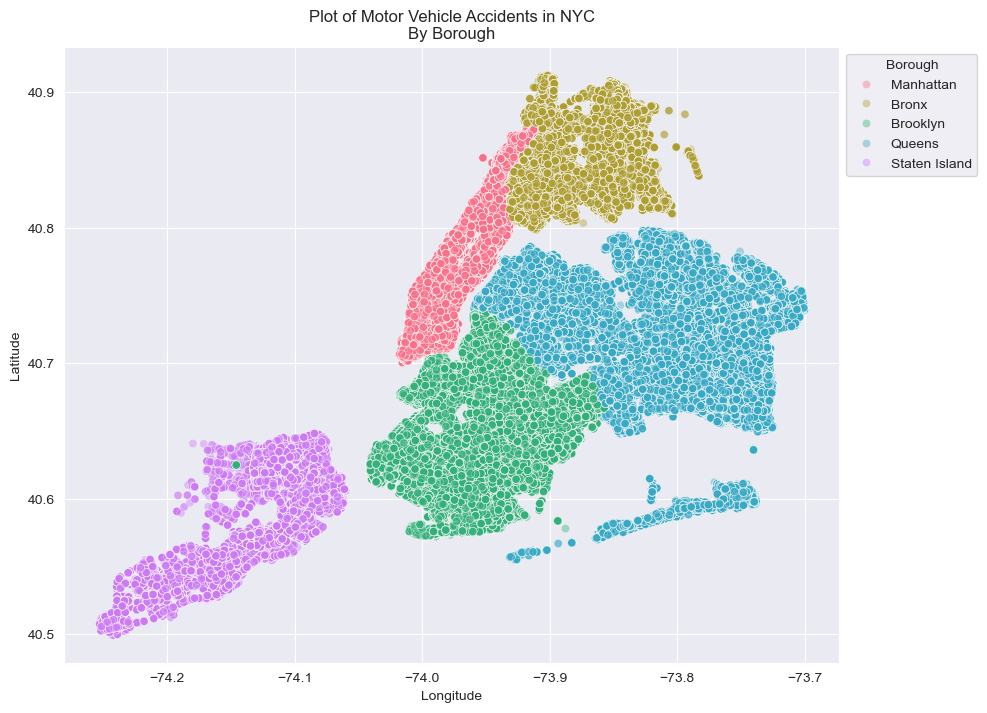

In [10]:
sns.set_palette([deep_colors[0]])
sns.set_style("darkgrid", {"grid.alpha": 0.2})

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df, x='longitude', y='latitude',
    hue='borough', alpha=.4
)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Plot of Motor Vehicle Accidents in NYC\nBy Borough')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Borough")
plt.show()

Most accidents are with Licensed drivers:

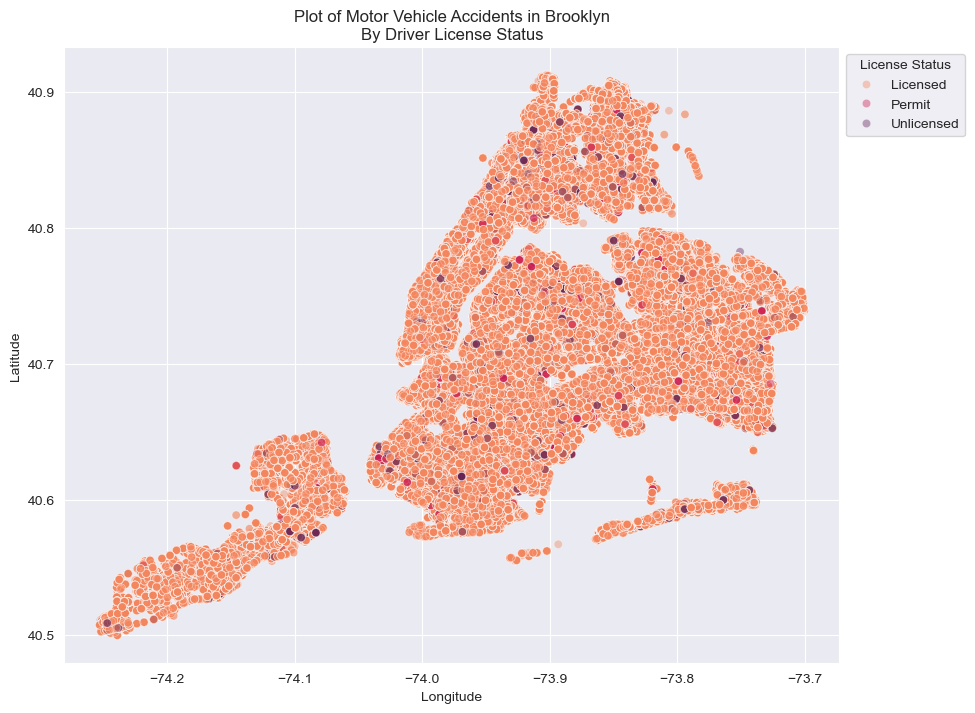

In [11]:
sns.set_palette([deep_colors[0]])
sns.set_style("darkgrid", {"grid.alpha": 0.2})

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df, x='longitude', y='latitude',
    hue='driver_license_status', palette='rocket_r', 
    alpha=.4
)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Plot of Motor Vehicle Accidents in Brooklyn\nBy Driver License Status')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="License Status")
plt.show()

Most accidents are by male drivers:

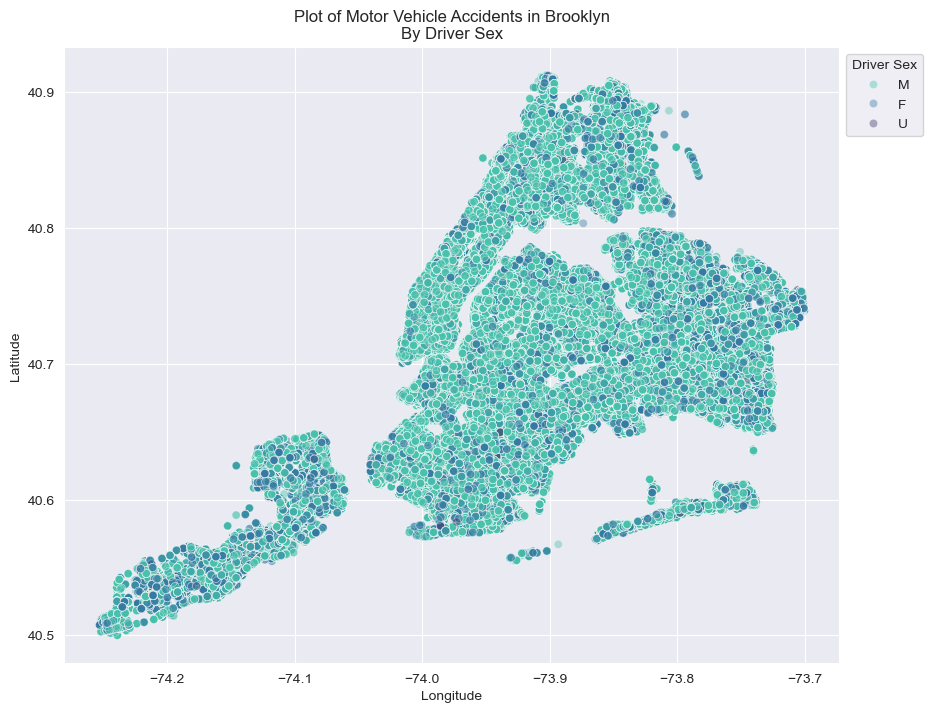

In [12]:
sns.set_palette([deep_colors[0]])
sns.set_style("darkgrid", {"grid.alpha": 0.2})

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df, x='longitude', y='latitude',
    hue='driver_sex', palette='mako_r', 
    alpha=.4
)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Plot of Motor Vehicle Accidents in Brooklyn\nBy Driver Sex')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Driver Sex")
plt.show()

**Time Series Analysis on Accidents**

2. Which time has the most accidents?
3. Which day of the week has the most accidents?
3b. Anomaly Detection—to determine when accidents are out of the ordinary

The timeframe of the dataset is between 2012 and 2021.

On average, accidents occur mostly in the hot months of May and June. However, the spread of average accidents between months is negligible.

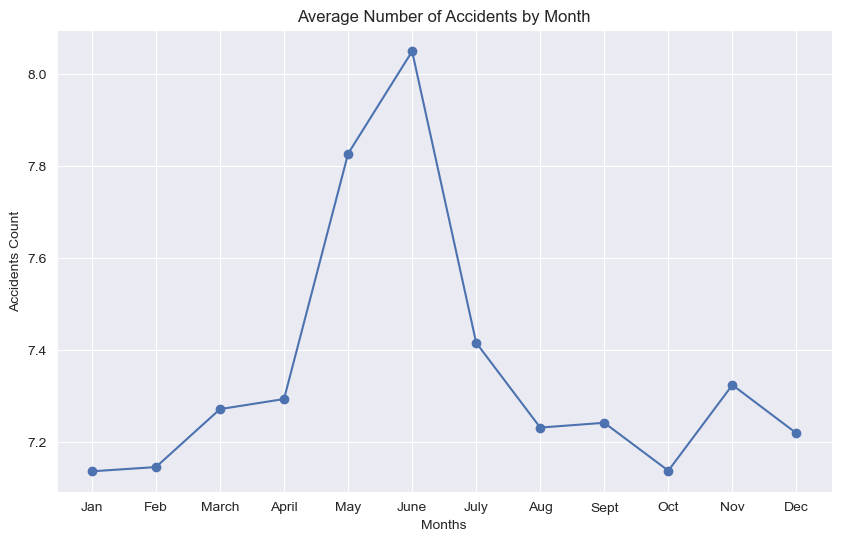

In [13]:
data = df.index.value_counts()
data_mean = data.groupby(data.index.month).mean()

month_mapping = {
    1: 'Jan', 2: 'Feb', 3: 'March', 4: 'April',
    5: 'May', 6: 'June', 7: 'July', 8: 'Aug',
    9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}
data_mean.index = data_mean.index.map(month_mapping)

plt.figure(figsize=(10, 6))
plt.plot(data_mean.index, data_mean, marker='o', linestyle='-')
plt.xlabel('Months')
plt.ylabel('Accidents Count')
plt.title('Average Number of Accidents by Month')
plt.show()

There is a significant spike in the number of recorded accidents from 2016.

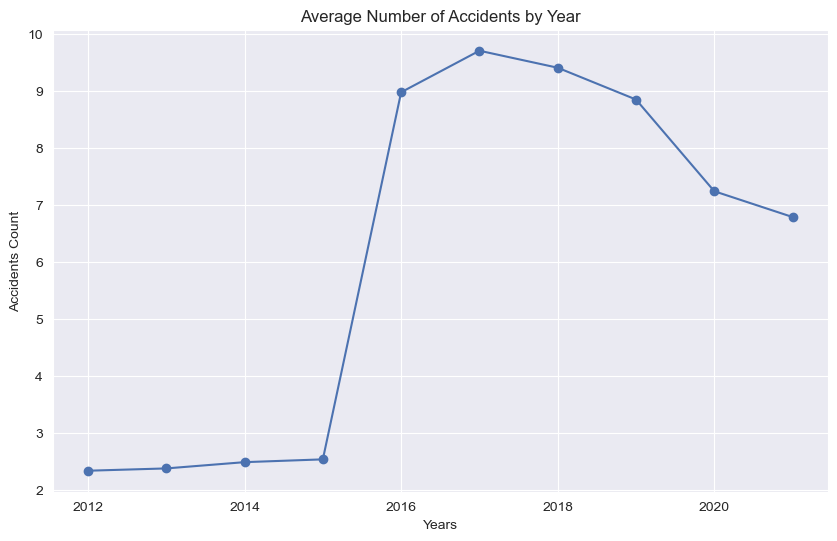

In [14]:
data = df.index.value_counts()
data_mean = data.groupby(data.index.year).mean()

plt.figure(figsize=(10, 6))
plt.plot(data_mean.index, data_mean, marker='o', linestyle='-')
plt.xlabel('Years')
plt.ylabel('Accidents Count')
plt.title('Average Number of Accidents by Year')
plt.show()

On average most accidents occur in the middle of the month.

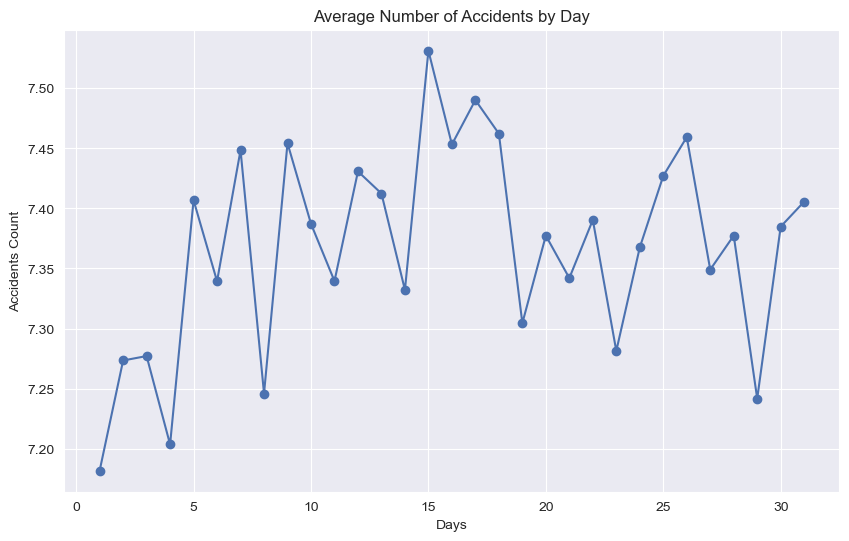

In [15]:
data = df.index.value_counts()
data_mean = data.groupby(data.index.day).mean()

plt.figure(figsize=(10, 6))
plt.plot(data_mean.index, data_mean, marker='o', linestyle='-')
plt.xlabel('Days')
plt.ylabel('Accidents Count')
plt.title('Average Number of Accidents by Day')
plt.show()

Most accidents occur at midnight:

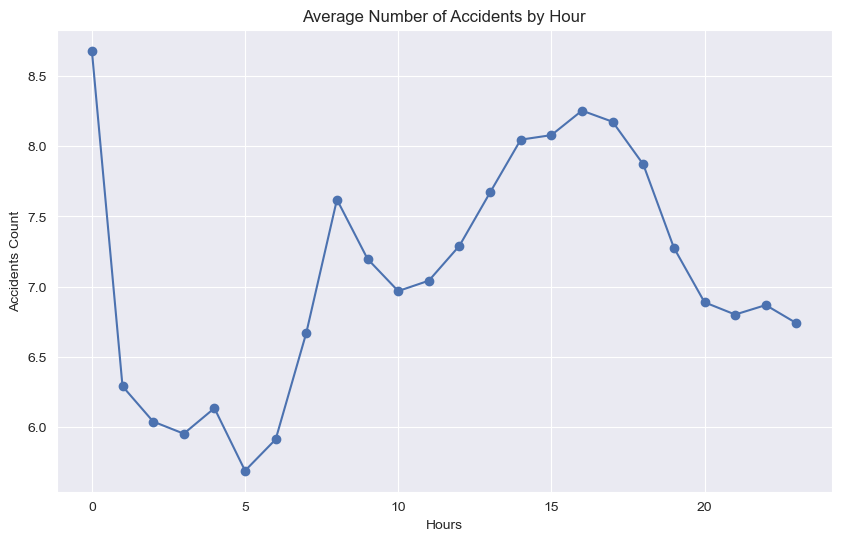

In [16]:
data = df.index.value_counts()
data_mean = data.groupby(data.index.hour).mean()

plt.figure(figsize=(10, 6))
plt.plot(data_mean.index, data_mean, marker='o', linestyle='-')
plt.xlabel('Hours')
plt.ylabel('Accidents Count')
plt.title('Average Number of Accidents by Hour')
plt.show()

**Anomaly Detection**

Anomaly detection in time series data is the process of identifying data points or patterns that deviate significantly from the expected or normal behavior. Anomalies, also known as outliers, can indicate errors, unusual events, or important insights.

We'll be using the following techniques to perform anomaly detection on our data:
* Seasonal Decomposition
* Statistical Methods (Z-Score)
* Moving Average
* Exponential Smoothing

Seasonal Decomposition: 

Here, we'll decompose the time series into trend, seasonality, and residual components. Anomalies might appear as extreme values in the residual component.

In [17]:
data = df.index.value_counts()
data.head()

crash_datetime
2020-06-30 13:20:00    726
2021-01-15 18:07:00    450
2021-01-21 17:00:00    182
2018-10-17 18:10:00    182
2017-09-04 22:45:00    144
Name: count, dtype: int64

Time Series Plot:

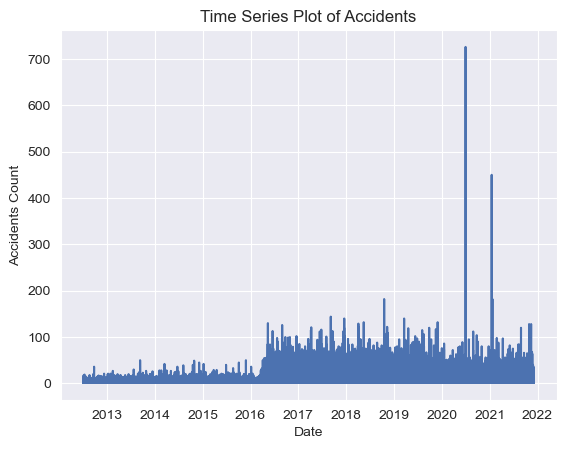

In [18]:
sns.lineplot(x='crash_datetime', y='count', data=data.reset_index())
plt.xlabel('Date')
plt.ylabel('Accidents Count')
plt.title('Time Series Plot of Accidents')
plt.show()

Decompose the time series into its trend, seasonality, and residual components:

In [19]:
data = data.asfreq('D').bfill()

decomposition = seasonal_decompose(data, model='additive')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

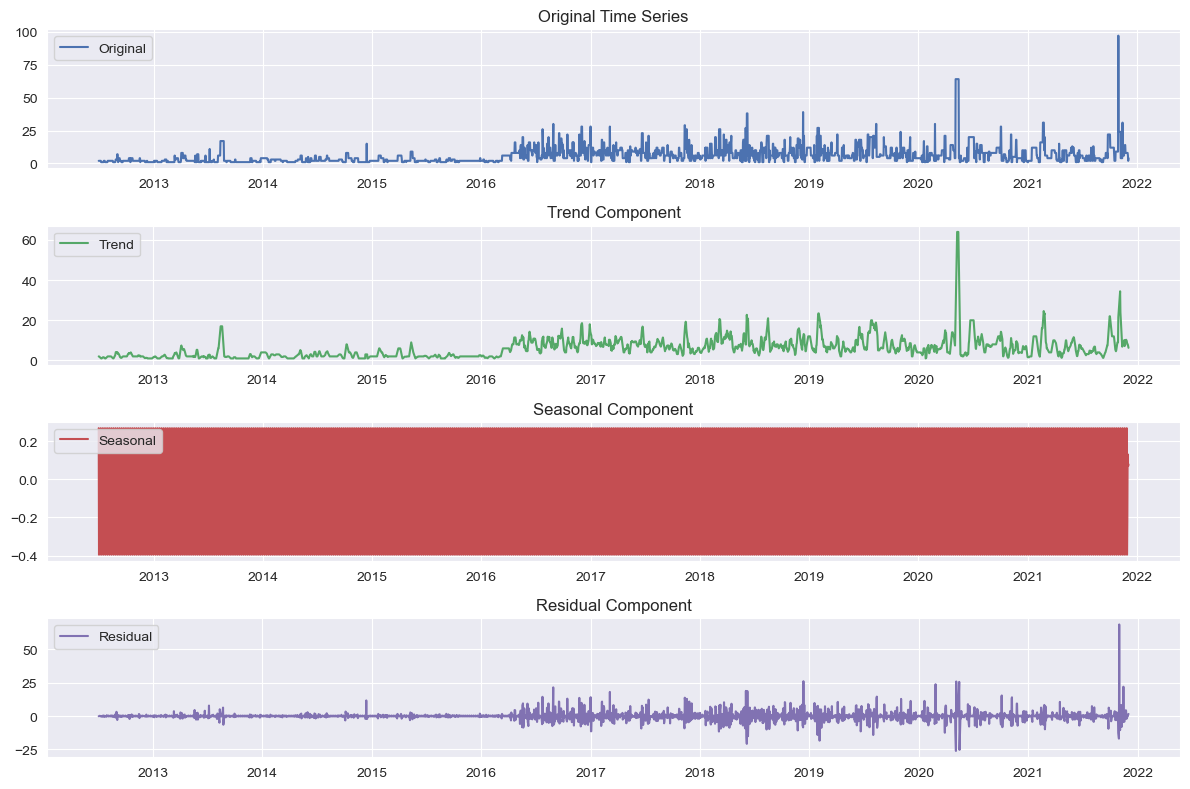

In [20]:
# Plot the original time series
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(data, label='Original', color=deep_colors[0])
plt.legend(loc='upper left')
plt.title('Original Time Series')

# Plot the trend component
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color=deep_colors[1])
plt.legend(loc='upper left')
plt.title('Trend Component')

# Plot the seasonal component
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal', color=deep_colors[2])
plt.legend(loc='upper left')
plt.title('Seasonal Component')

# Plot the residual component
plt.subplot(414)
plt.plot(decomposition.resid, label='Residual', color=deep_colors[3])
plt.legend(loc='upper left')
plt.title('Residual Component')

plt.tight_layout()
plt.show()

Deep dive into seasonality:

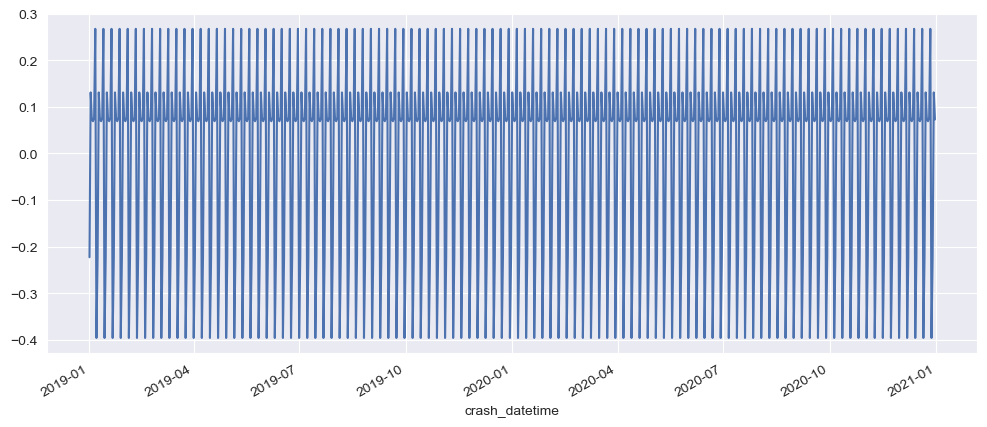

In [21]:
plt.figure(figsize=(12, 5))
decomposition.seasonal["2019":"2020"].plot();

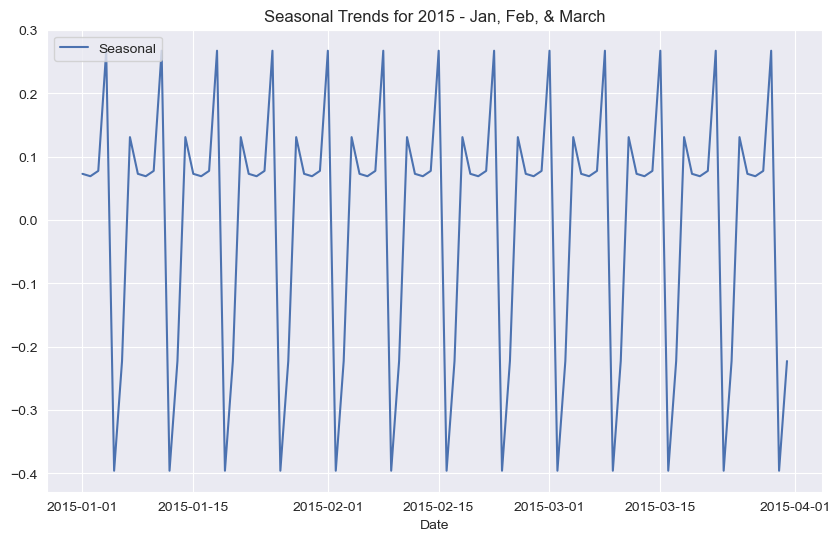

In [22]:
year = 2015
months_to_select = [1, 2, 3]  

selected_data = seasonal[(seasonal.index.year == year) & (seasonal.index.month.isin(months_to_select))]

plt.figure(figsize=(10, 6))
plt.plot(selected_data, label='Seasonal')
plt.xlabel('Date')
plt.title(f'Seasonal Trends for {year} - Jan, Feb, & March')
plt.legend(loc='upper left')
plt.show()

When the seasonal plot is reduced to its lowest form, it shows a weekly spike and subsequent drop in accidents:

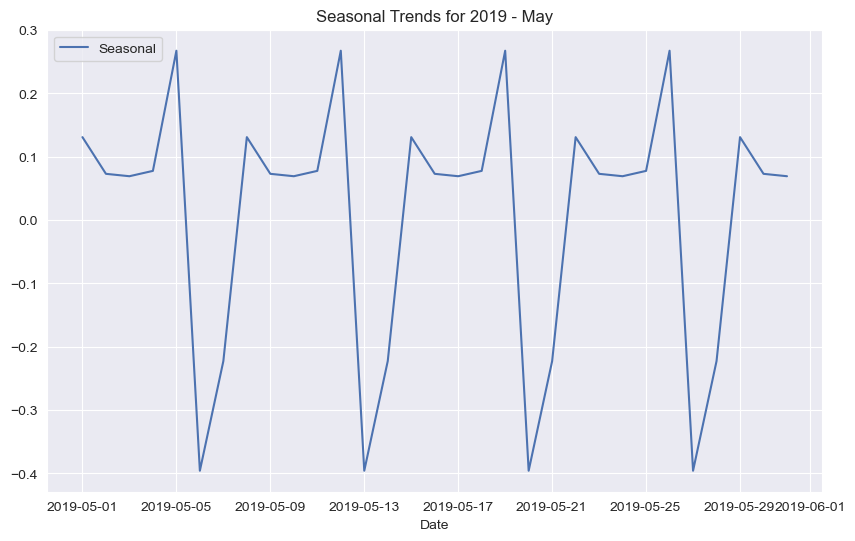

In [23]:
year = 2019
months_to_select = [5]

selected_data = seasonal[(seasonal.index.year == year) & (seasonal.index.month.isin(months_to_select))]

plt.figure(figsize=(10, 6))
plt.plot(selected_data, label='Seasonal')
plt.xlabel('Date')
plt.title(f'Seasonal Trends for {year} - May')
plt.legend(loc='upper left')
plt.show()

Let's compute decomposition by Borough:

In [24]:
print(df.loc[df.borough=='Brooklyn'].index.value_counts().shape, df.loc[df.borough=='Bronx'].index.value_counts().shape, df.loc[df.borough=='Staten Island'].index.value_counts().shape)

(142948,) (70882,) (20093,)


In [25]:
seasonality_dict = dict()
trend_dict = dict()
resid_dict = dict()

for bor in df.borough.unique():
    data = df.loc[df.borough==bor].index.value_counts().asfreq(freq='D').bfill().sort_index()
    
    decomposition = seasonal_decompose(data.dropna())
    seasonality_dict[bor] = decomposition.seasonal
    trend_dict[bor] = decomposition.trend
    resid_dict[bor] = decomposition.resid

Let's plot the seasonality by Borough:

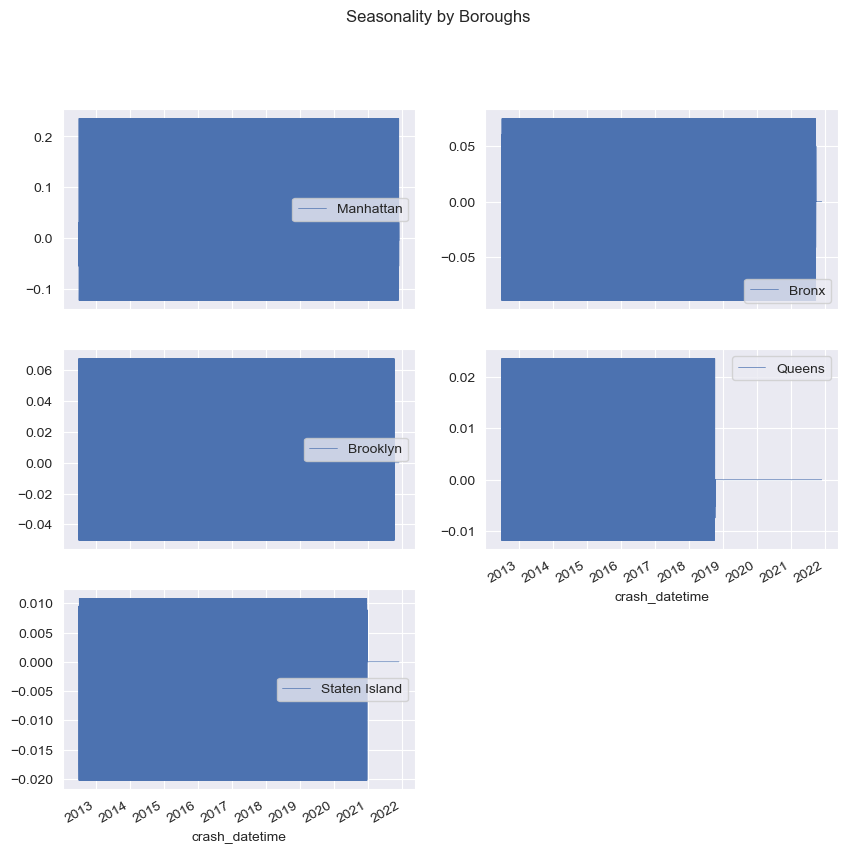

In [26]:
pd.DataFrame(seasonality_dict).fillna(0).plot(
    subplots=True, layout=(3, 2), linewidth=.5, figsize=(10, 10), title='Seasonality by Boroughs'
);

Let's plot the trend by Borough:

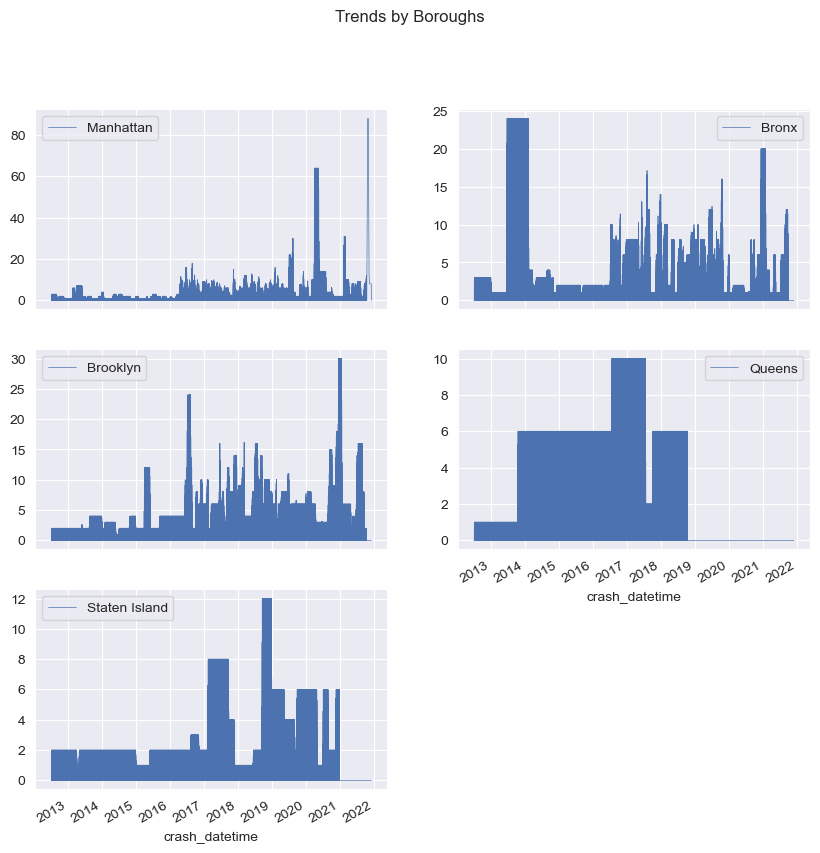

In [27]:
pd.DataFrame(trend_dict).fillna(0).plot(
    subplots=True, layout=(3, 2), linewidth=.5, figsize=(10, 10), title='Trends by Boroughs'
);

Let's plot the noise by Borough:

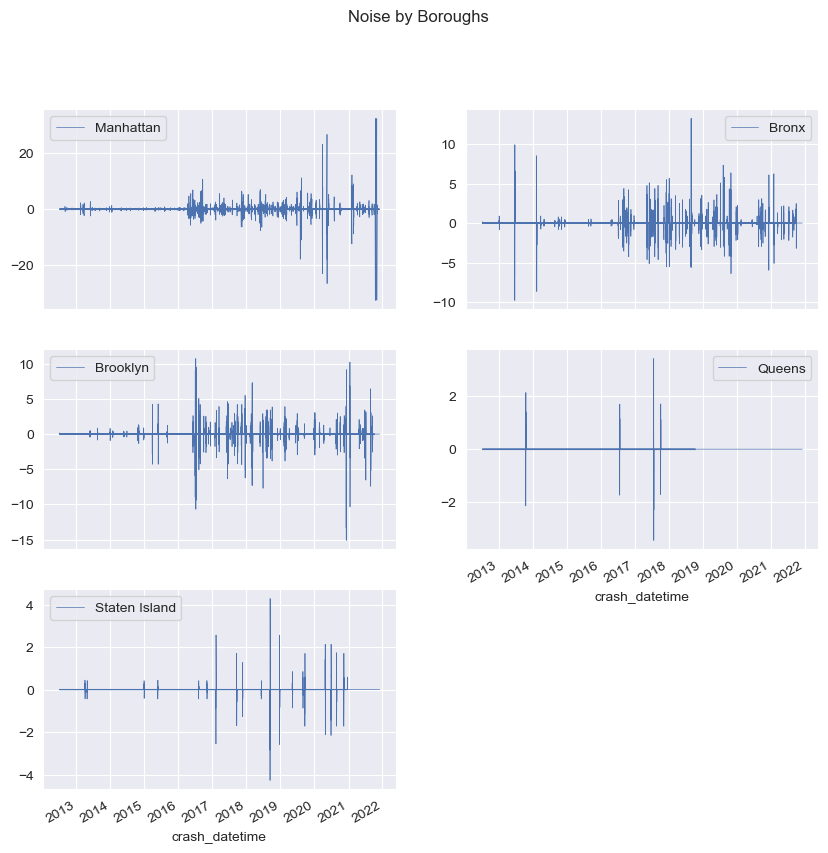

In [28]:
pd.DataFrame(resid_dict).fillna(0).plot(
    subplots=True, layout=(3, 2), linewidth=.5, figsize=(10, 10), title='Noise by Boroughs'
);

Anomaly Detection Using Statistical Methods:

We'll calculate the z-score for each data point and identify anomalies by setting a z-score threshold.

In [29]:
data = pd.DataFrame({'accidents_count': df.index.value_counts(), 'z_score':stats.zscore(df.index.value_counts().values)})
data.head()

accidents_count    z_score
crash_datetime                                 
2020-06-30 13:20:00              726  95.133657
2021-01-15 18:07:00              450  58.596381
2021-01-21 17:00:00              182  23.118156
2018-10-17 18:10:00              182  23.118156
2017-09-04 22:45:00              144  18.087661

<Figure size 1200x600 with 0 Axes>

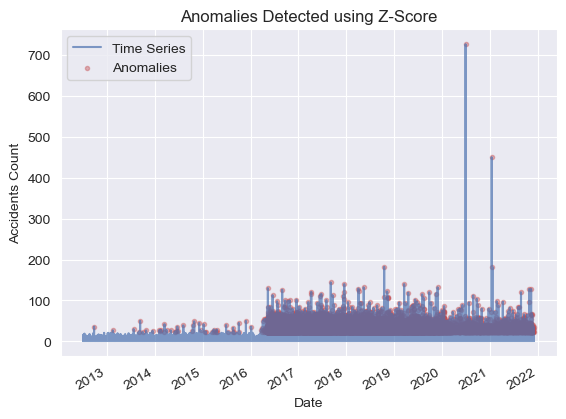

In [30]:
# Set a z-score threshold for anomaly detection
z_score_threshold = 2.0
data['anomaly_z_score'] = data.z_score.apply(lambda x: 1 if abs(x) > z_score_threshold else 0)

# Plot anomalies
plt.figure(figsize=(12, 6))
data.plot(
    y='accidents_count', label='Time Series',
    color=deep_colors[0], alpha=.7
)
plt.scatter(
    data.loc[data.anomaly_z_score == 1].index, 
    data.loc[data.anomaly_z_score == 1].accidents_count, 
    color=deep_colors[2], label='Anomalies', alpha=.4,
    marker='.'
)
plt.title('Anomalies Detected using Z-Score')
plt.xlabel('Date')
plt.ylabel('Accidents Count')
plt.legend()
plt.show()

There are 16k+ anomaly points in the dataset, which represent 4% of the accidents:

In [31]:
data.anomaly_z_score.sum(), data.shape[0], 

(15880, 372542)

In [32]:
data.anomaly_z_score.sum() / data.shape[0]

0.042626066322723345

Anomaly Detection Using Moving Average:

We'll use a rolling average and identify anomalies when data points deviate significantly from the moving average.

In [33]:
data = pd.DataFrame({'accidents_count': df.index.value_counts(), 'z_score':stats.zscore(df.index.value_counts().values)})
data.head()

accidents_count    z_score
crash_datetime                                 
2020-06-30 13:20:00              726  95.133657
2021-01-15 18:07:00              450  58.596381
2021-01-21 17:00:00              182  23.118156
2018-10-17 18:10:00              182  23.118156
2017-09-04 22:45:00              144  18.087661

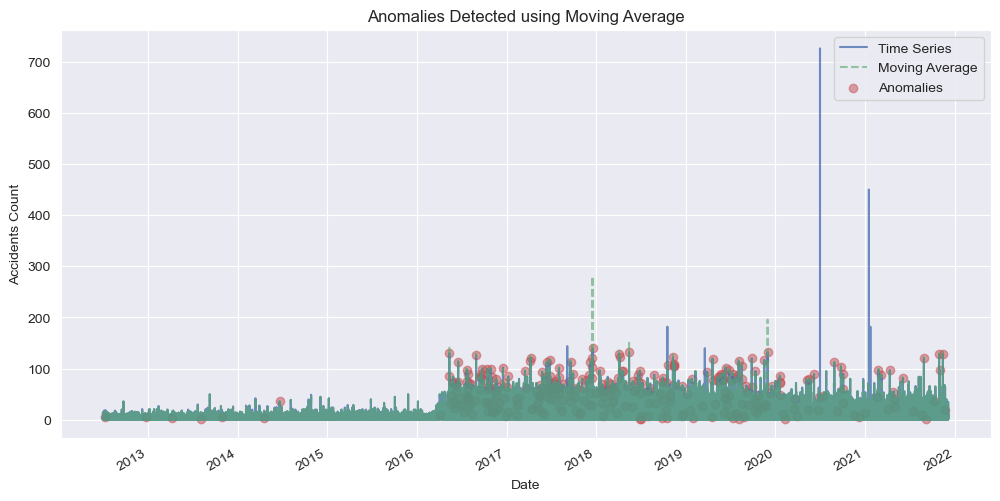

In [34]:
window_size = 7  # Adjust the window size as needed

# Calculate the moving average
data['moving_avg'] = data.accidents_count.rolling(window=window_size).mean()

# Set a threshold for anomaly detection
moving_avg_threshold = 0.5  # Adjust the threshold as needed
data['anomaly_moving_avg'] = data.accidents_count.sub(
    data.moving_avg
    ).abs().apply(lambda x: 1 if x > moving_avg_threshold else 0)

# Plot anomalies
fig, ax = plt.subplots(figsize=(12, 6))
data.plot(
    y='accidents_count', label='Time Series',
    color=deep_colors[0], alpha=.8, ax =ax
    )
data.plot(
    y='moving_avg', label='Moving Average', linestyle='--', 
    color=deep_colors[1], alpha=.6, ax =ax
    )
ax.scatter(
    data.loc[data.anomaly_moving_avg == 1].index, 
    data.loc[data.anomaly_moving_avg == 1].accidents_count, 
    color=deep_colors[2], label='Anomalies', alpha=.5
    )
plt.title('Anomalies Detected using Moving Average')
plt.xlabel('Date')
plt.ylabel('Accidents Count')
plt.legend()
plt.show()

Exponential Smoothing:

We'll use exponential smoothing to create a smoothed version of the time series and identify anomalies when data points deviate from the smoothed values.

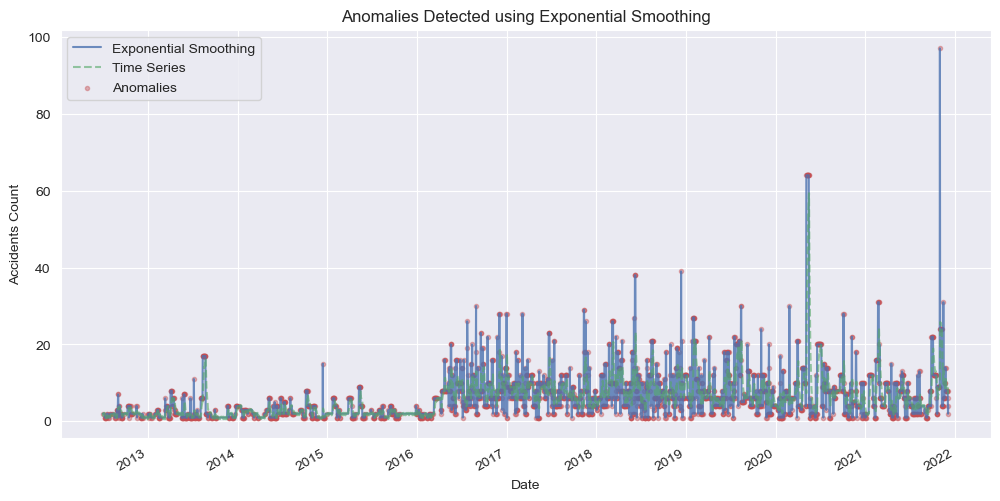

In [35]:
# Apply exponential smoothing
data2 = data.asfreq('D').bfill()
alpha = 0.2  # Smoothing parameter
data2['exponential_smoothed'] = ExponentialSmoothing(
    data2.accidents_count, trend='add', seasonal='add',
    seasonal_periods=7, initialization_method='estimated', 
    freq='D'
    ).fit(smoothing_level=alpha).fittedvalues

# Set a threshold for anomaly detection
exp_smoothing_threshold = 0.5
data2['anomaly_exp_smoothing'] = data2.accidents_count.sub(
    data2.exponential_smoothed
    ).abs().apply(lambda x: 1 if x > exp_smoothing_threshold else 0)

# Plot anomalies
fig, ax = plt.subplots(figsize=(12, 6))
data2.plot(
    y='accidents_count', label='Exponential Smoothing',
    color=deep_colors[0], alpha=.8, ax=ax
    )
data2.plot(
    y='exponential_smoothed', label='Time Series', linestyle='--',
    color=deep_colors[1], alpha=.6, ax=ax
    )
ax.scatter(
    data2.loc[data2.anomaly_exp_smoothing == 1].index, 
    data2.loc[data2.anomaly_exp_smoothing == 1].accidents_count, 
    color=deep_colors[2], label='Anomalies', alpha=.4, marker='.'
    )
plt.title('Anomalies Detected using Exponential Smoothing')
plt.xlabel('Date')
plt.ylabel('Accidents Count')
plt.legend()
plt.show()


4. Accident Trends over time

Plotting Time Series of Accidents by Borough

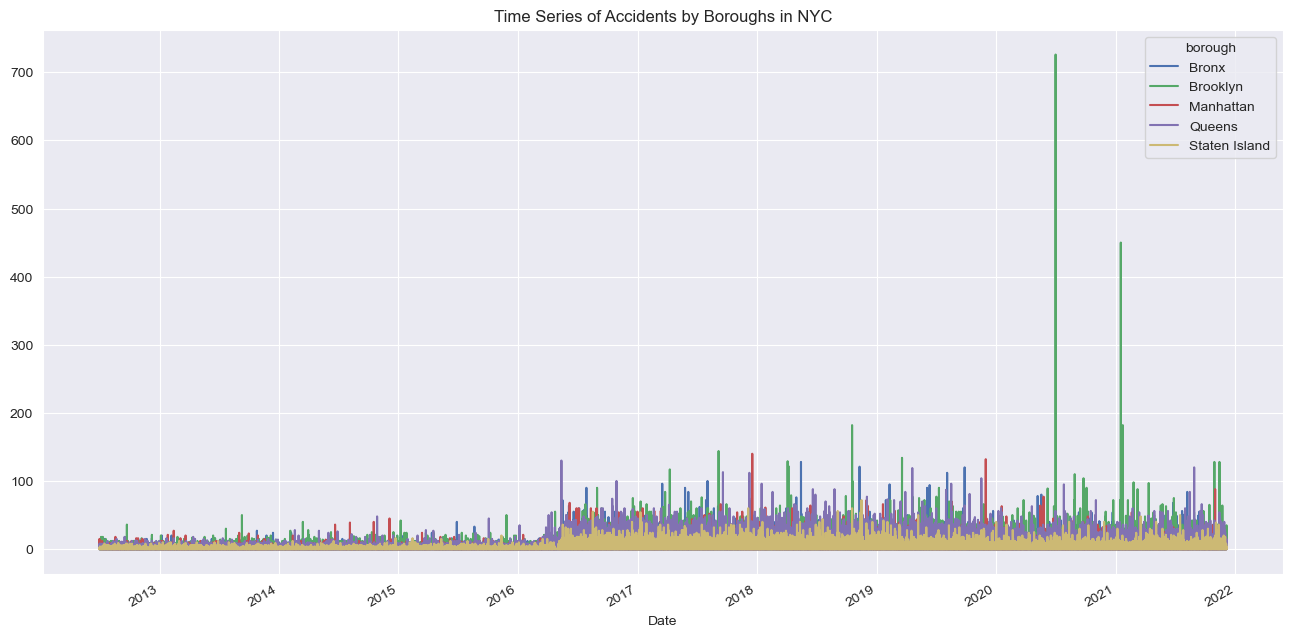

In [36]:
data = df.groupby([df.index, 'borough']).collision_id.size().unstack().fillna(0)

data.plot(
    figsize=(16, 8), title="Time Series of Accidents by Boroughs in NYC", color=deep_colors[:5]
)
plt.xlabel("Date");

Trend for Average Counts shows similar trends across boroughs. Trend seems to tend downwards after a sharp spike in 2016, although Manhattan & Queens saw more significant drops than others in 2020.

<Figure size 700x500 with 0 Axes>

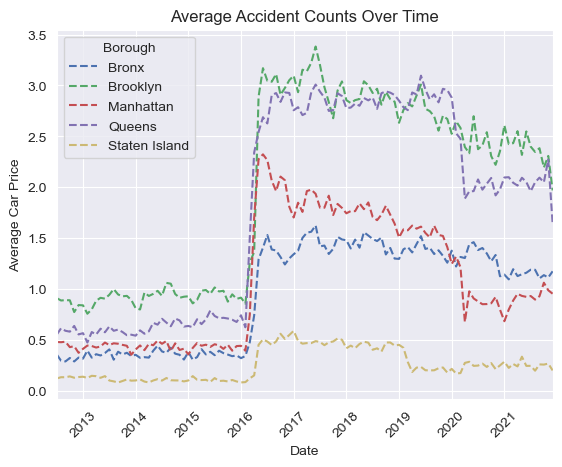

In [37]:
monthly_mean = data.resample('M').mean().interpolate()

plt.figure(figsize=(7, 5))
monthly_mean.plot(
    linestyle='--', color=deep_colors[:5],
    title='Average Accident Counts Over Time',
    xlabel='Date', ylabel='Average Car Price'
)
plt.xticks(rotation=45)
plt.legend(title='Borough')
plt.show()

**Numeric Distributions**

5. How many victims on average per accident?
6. Registration Year for cars in accidents.

In [38]:
victim_cols = [
    'number_of_persons_injured', 'number_of_persons_killed', 
    'number_of_pedestrians_injured', 'number_of_pedestrians_killed', 
    'number_of_cyclist_injured', 'number_of_cyclist_killed',
    'number_of_motorist_injured', 'number_of_motorist_killed'
]

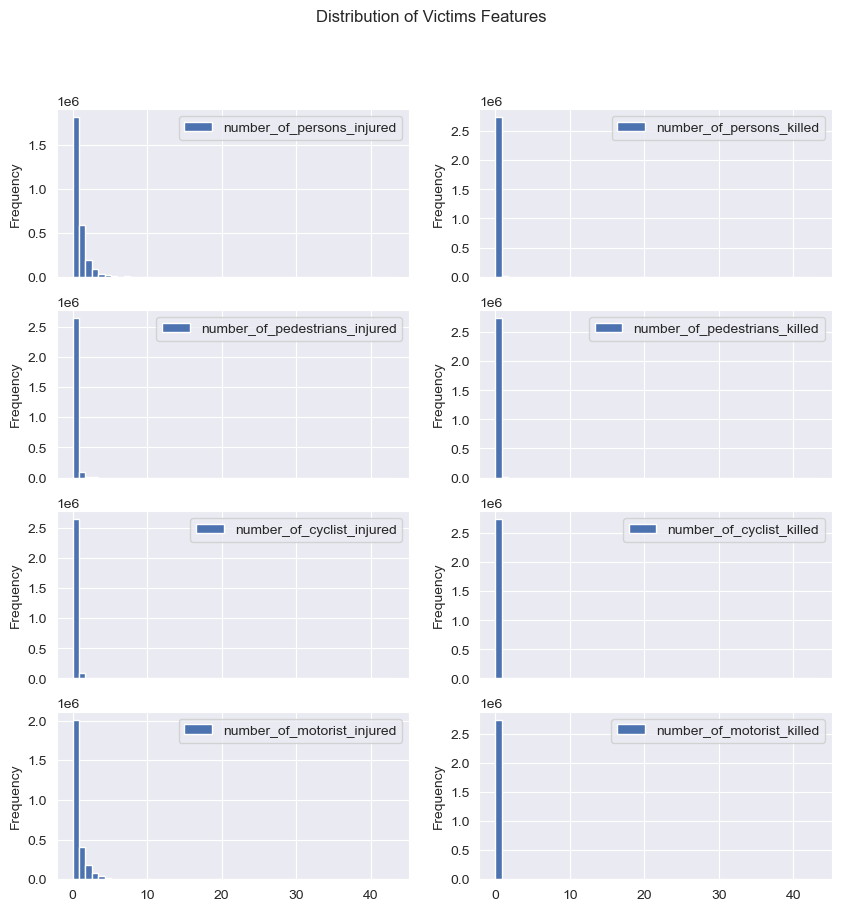

In [39]:
df[victim_cols].plot(
    subplots=True, layout=(4, 2), kind='hist', bins=50,
    figsize=(10, 10), title='Distribution of Victims Features'
);

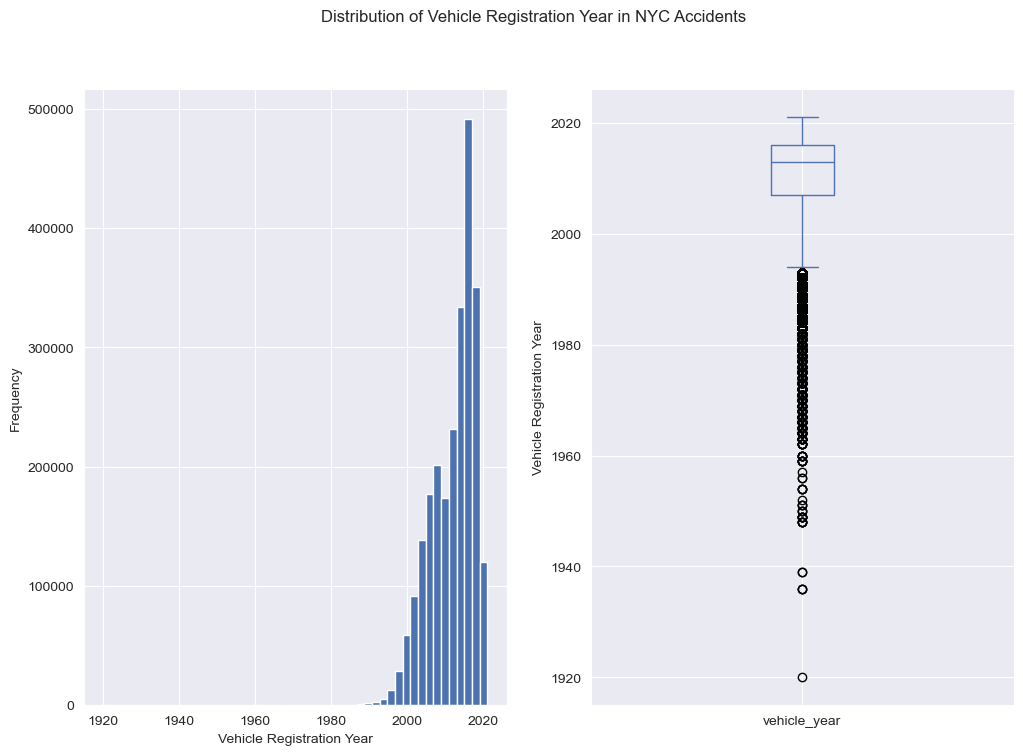

In [40]:
plt.figure(figsize=(12, 8))

plt.subplot(121)
df.vehicle_year.plot(kind='hist', bins=50, xlabel='Vehicle Registration Year')

plt.subplot(122)
df.vehicle_year.plot(kind='box', ylabel='Vehicle Registration Year')

plt.suptitle('Distribution of Vehicle Registration Year in NYC Accidents')
plt.show()

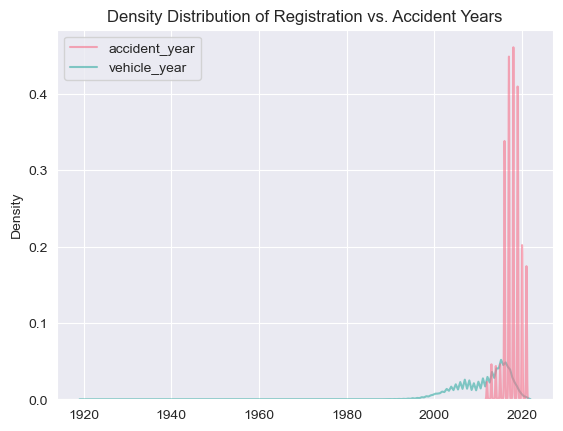

In [41]:
sns.kdeplot(
    data=df.assign(
        accident_year=lambda x: x.index.year
        )[['accident_year', 'vehicle_year']],
    color=deep_colors[-2:], alpha=.6,
    legend=True
)

plt.title('Density Distribution of Registration vs. Accident Years')
plt.show()

**Likelihood Analysis**

7. Using vehicle year, what is the likelihood that an accident will result in injury or death?

In [42]:
data = df[['vehicle_year', 'number_of_persons_injured', 'number_of_persons_killed']]
data.sample(5)

vehicle_year  number_of_persons_injured  \
crash_datetime                                                 
2017-11-25 09:00:00        2014.0                          1   
2018-09-21 10:30:00        2016.0                          0   
2018-10-02 07:00:00        2014.0                          0   
2014-03-28 18:08:00           NaN                          3   
2018-05-23 21:55:00        2013.0                          1   

                     number_of_persons_killed  
crash_datetime                                 
2017-11-25 09:00:00                         0  
2018-09-21 10:30:00                         0  
2018-10-02 07:00:00                         0  
2014-03-28 18:08:00                         0  
2018-05-23 21:55:00                         0

12% of the dataset does not have information for vehicle year. We'll replace it with the average:

In [43]:
df.vehicle_year.isnull().sum() / df.shape[0]

0.11645078428157621

In [44]:
df.vehicle_year.describe()

count    2.424945e+06
mean     2.011432e+03
std      5.817887e+00
min      1.920000e+03
25%      2.007000e+03
50%      2.013000e+03
75%      2.016000e+03
max      2.021000e+03
Name: vehicle_year, dtype: float64

If we replace the missing values with the average, we have a new mode, but otherwise, the spread is not oo different. We'll go ahead and apply the replacement.

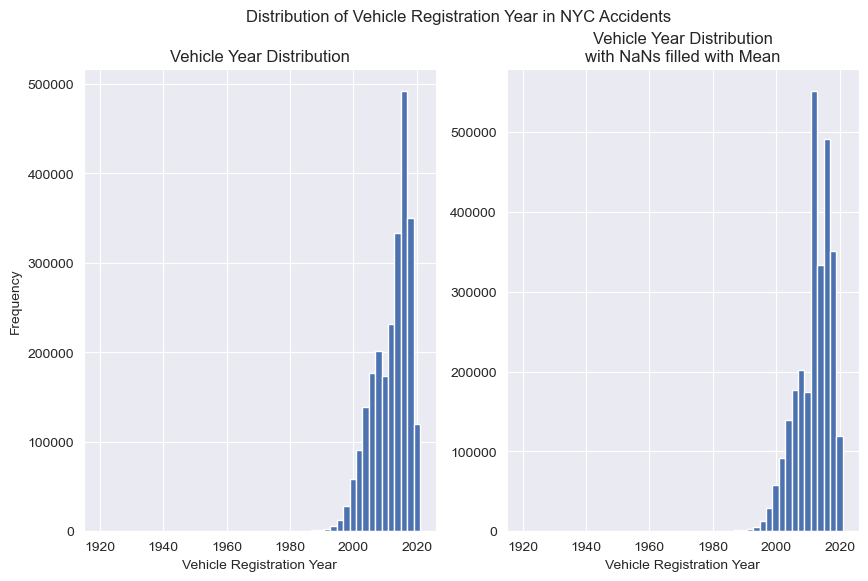

In [45]:
plt.figure(figsize=(10, 6))

plt.subplot(121)
df.vehicle_year.plot(
    kind='hist', bins=50, 
    xlabel='Vehicle Registration Year',
    title='Vehicle Year Distribution'
    )

plt.subplot(122)
df.vehicle_year.fillna(int(df.vehicle_year.mean())).astype(float).plot(
    kind='hist', bins=50, 
    xlabel='Vehicle Registration Year',
    title='Vehicle Year Distribution\nwith NaNs filled with Mean',
    ylabel=''
)

plt.suptitle('Distribution of Vehicle Registration Year in NYC Accidents')
plt.show()

In [46]:
data['vehicle_year'] = data['vehicle_year'].fillna(int(data.vehicle_year.mean())).astype(float)
data.head()

/var/folders/t4/x7zw1vdd2gx4d5lg3pnpdnwm0000gn/T/ipykernel_88855/444811767.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['vehicle_year'] = data['vehicle_year'].fillna(int(data.vehicle_year.mean())).astype(float)


vehicle_year  number_of_persons_injured  \
crash_datetime                                                 
2012-07-01 00:30:00        2011.0                          1   
2012-07-01 00:30:00        2011.0                          1   
2012-07-01 00:37:00        2011.0                          1   
2012-07-01 00:37:00        2011.0                          1   
2012-07-01 01:00:00        2011.0                          1   

                     number_of_persons_killed  
crash_datetime                                 
2012-07-01 00:30:00                         0  
2012-07-01 00:30:00                         0  
2012-07-01 00:37:00                         0  
2012-07-01 00:37:00                         0  
2012-07-01 01:00:00                         0

In [47]:
grouped = data.groupby(by='vehicle_year')[
    ['number_of_persons_injured', 'number_of_persons_killed']
    ].agg(['mean', 'median', 'sum'])
grouped

number_of_persons_injured               number_of_persons_killed  \
                                  mean median    sum                     mean   
vehicle_year                                                                    
1920.0                        1.000000    1.0      1                 0.000000   
1936.0                        1.000000    1.0      3                 0.000000   
1939.0                        0.000000    0.0      0                 0.000000   
1948.0                        0.000000    0.0      0                 0.000000   
1949.0                        0.500000    0.5      3                 0.000000   
...                                ...    ...    ...                      ...   
2017.0                        0.435617    0.0  94335                 0.001445   
2018.0                        0.460085    0.0  61684                 0.001708   
2019.0                        0.543706    0.0  41643                 0.002298   
2020.0                        0.691241    0.0  21134                 0.004317   
2021.0                        0.764077    0.0   9784                 0.004061   

                          
             median  sum  
vehicle_year              
1920.0          0.0    0  
1936.0          0.0    0  
1939.0          0.0    0  
1948.0          0.0    0  
1949.0          0.0    0  
...             ...  ...  
2017.0          0.0  313  
2018.0          0.0  229  
2019.0          0.0  176  
2020.0          0.0  132  
2021.0          0.0   52  

[73 rows x 6 columns]

How does the distribution of accident severity vary by vehicle year?

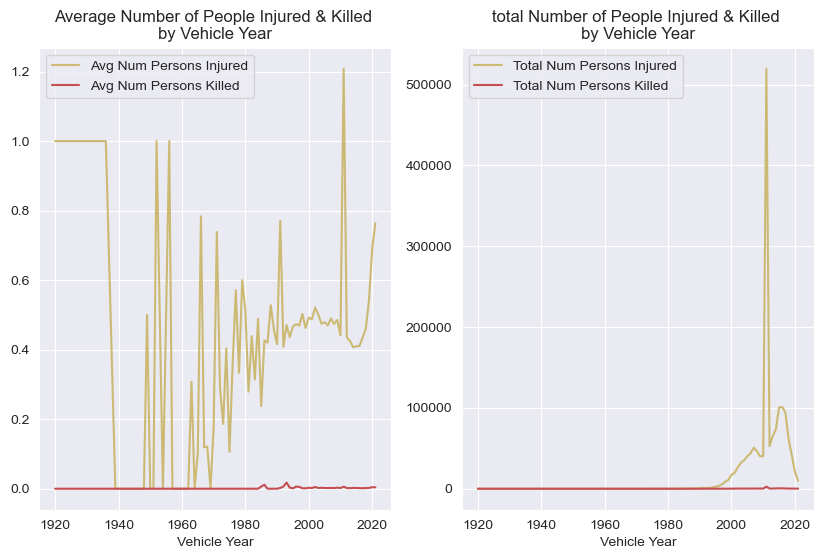

In [48]:
plt.figure(figsize=(10, 6))

plt.subplot(121)
grouped[('number_of_persons_injured', 'mean')].plot(
    xlabel='Vehicle Year', color=deep_colors[4], legend=True, 
    label='Avg Num Persons Injured'
    )
grouped[('number_of_persons_killed', 'mean')].plot(
    xlabel='Vehicle Year', color=deep_colors[2], legend=True,
    label='Avg Num Persons Killed',
    title='Average Number of People Injured & Killed \nby Vehicle Year'
    )

plt.subplot(122)
grouped[('number_of_persons_injured', 'sum')].plot(
    xlabel='Vehicle Year', color=deep_colors[4], legend=True, 
    label='Total Num Persons Injured'
    )
grouped[('number_of_persons_killed', 'sum')].plot(
    xlabel='Vehicle Year', color=deep_colors[2], legend=True,
    label='Total Num Persons Killed',
    title='total Number of People Injured & Killed \nby Vehicle Year'
    )

plt.show()

Let's test the hypotheses presented in these charts:

In [49]:
formula = 'number_of_persons_injured ~ vehicle_year'
model = smf.ols(formula, data=data)
results = model.fit()
print(results.summary())

                                OLS Regression Results                               
Dep. Variable:     number_of_persons_injured   R-squared:                       0.000
Model:                                   OLS   Adj. R-squared:                  0.000
Method:                        Least Squares   F-statistic:                     720.4
Date:                       Mon, 06 Nov 2023   Prob (F-statistic):          1.17e-158
Time:                               00:26:45   Log-Likelihood:            -4.2093e+06
No. Observations:                    2744550   AIC:                         8.419e+06
Df Residuals:                        2744548   BIC:                         8.419e+06
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

In [50]:
formula = 'number_of_persons_injured ~ vehicle_year'
model = smf.ols(formula, data=data.assign(
    vehicle_year=lambda x: x.vehicle_year.astype(str)
))
results = model.fit()
print(results.summary())

                                OLS Regression Results                               
Dep. Variable:     number_of_persons_injured   R-squared:                       0.061
Model:                                   OLS   Adj. R-squared:                  0.061
Method:                        Least Squares   F-statistic:                     2497.
Date:                       Mon, 06 Nov 2023   Prob (F-statistic):               0.00
Time:                               00:28:01   Log-Likelihood:            -4.1226e+06
No. Observations:                    2744550   AIC:                         8.245e+06
Df Residuals:                        2744477   BIC:                         8.246e+06
Df Model:                                 72                                         
Covariance Type:                   nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------

**Text Analysis**

8. Reasons for accidents.

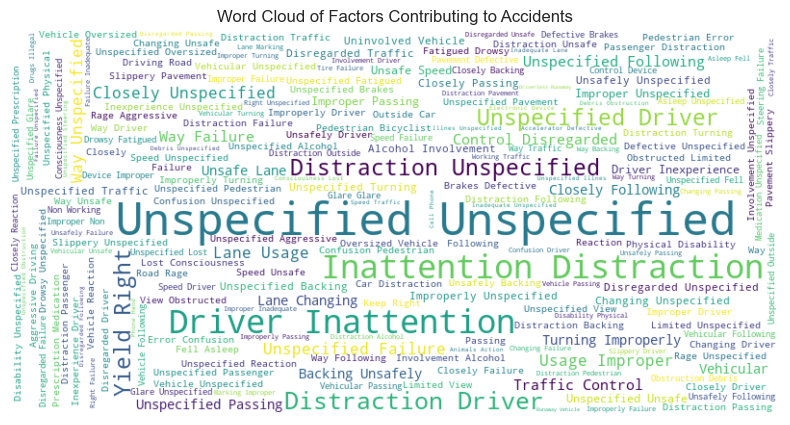

In [51]:
text = ' '.join(df['contributing_factor_1'].dropna().astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Factors Contributing to Accidents")
plt.show()

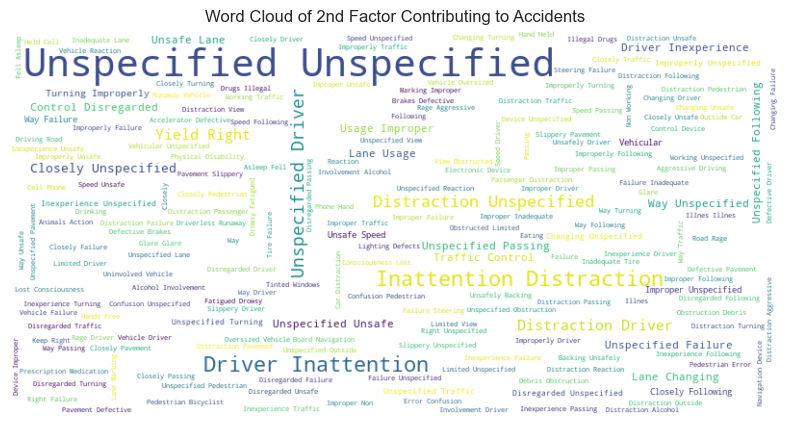

In [52]:
text = ' '.join(df['contributing_factor_2'].dropna().astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of 2nd Factor Contributing to Accidents")
plt.show()

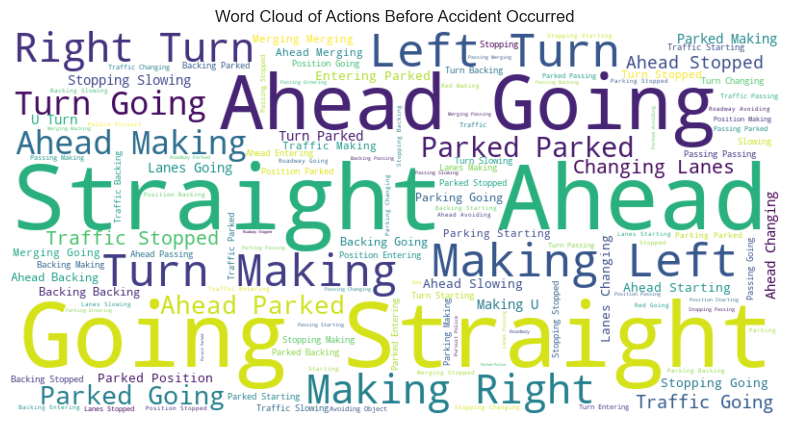

In [112]:
text = ' '.join(df['pre_crash'].dropna().astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Actions Before Accident Occurred")
plt.show()

**Most Popular Accident Intersections**

9. Which street corner / intersection is prone to accidents?

Most accidents occur around Flatbush Avenue Extension & Tillary Street (3708) in Brooklyn. This intersection is home to 2 hotels and a park. It has a traffic light and a speed limit of 25mph. The intersection is featured in a legal article on [dangerous intersections](https://www.thebarnesfirm.com/tillary-st-flatbush-ave-dangerous-intersections/#:~:text=drivers%20at%20risk.-,Speed,at%20risk%20of%20an%20accident).

Located just off I-278, this intersection has a lot of traffic coming from and going to the high-speed interstate; but these are surface streets with a 25mph speed limit. With nearby parks and hotels, this intersection also features a lot of foot traffic, making it even more dangerous for pedestrians crossing the street.

Since much of the traffic here is coming from the Manhattan Bridge or Interstate 278, many of the vehicles here may be moving much faster than what the speed limit permits.

The Bronx Borough has the majority of accident intersections.

In [53]:
combinations = df.groupby(['on_street_name', 'cross_street_name', 'borough']).size().reset_index(name='Count')

most_common = combinations.sort_values(
    by='Count', ascending=False
).assign(
    accident_intersection=lambda x: x.on_street_name + " - " +  x.cross_street_name,
).reset_index(drop=True)[
    ['accident_intersection', 'borough', 'Count']
]

top10 = most_common.head(10)
top10

accident_intersection   borough  Count
0  West Fordham Road - Major Deegan Expressway     Bronx   2843
1   Flatbush Avenue Extension - Tillary Street  Brooklyn   1948
2      Bruckner Boulevard - Hunts Point Avenue     Bronx   1904
3        Rockaway Boulevard - Brewer Boulevard    Queens   1893
4   Tillary Street - Flatbush Avenue Extension  Brooklyn   1722
5        North Conduit Avenue - Cohancy Street    Queens   1601
6     East Gun Hill Road - Bronx River Parkway     Bronx   1586
7       Rockaway Boulevard - Farmers Boulevard    Queens   1585
8            Atlantic Avenue - Eastern Parkway  Brooklyn   1403
9      Hunts Point Avenue - Bruckner Boulevard     Bronx   1392

In [54]:
top10.borough.value_counts()

borough
Bronx       4
Brooklyn    3
Queens      3
Name: count, dtype: int64

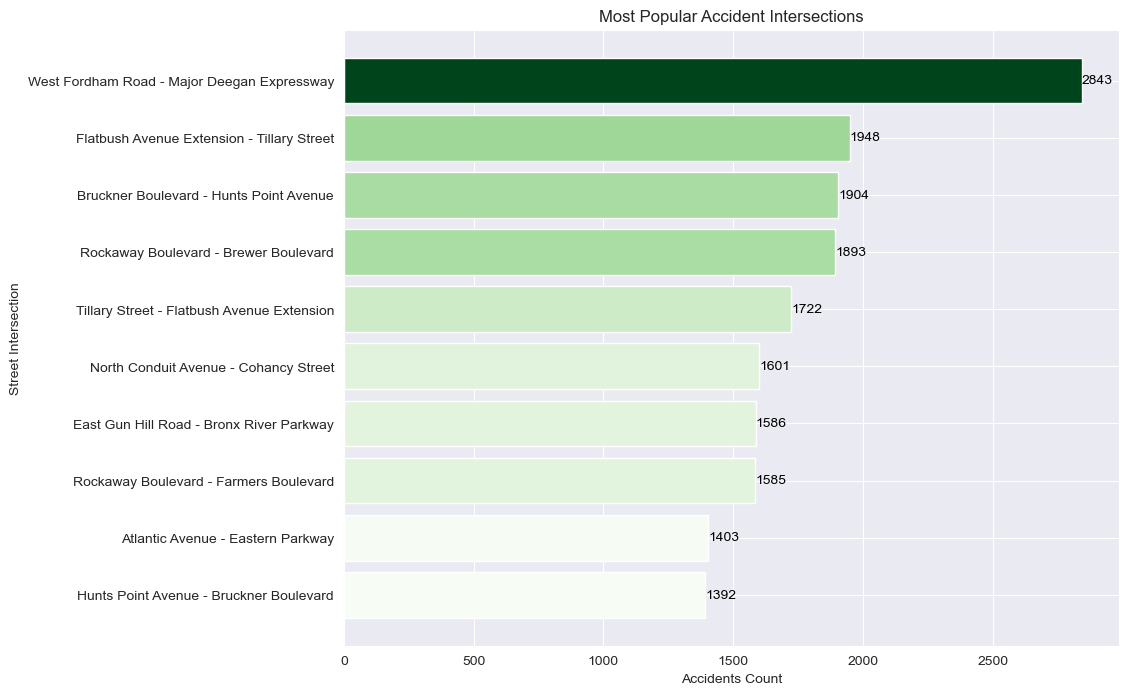

In [55]:
cmap = plt.get_cmap('Greens')
normalize = plt.Normalize(min(top10.Count), max(top10.Count))

plt.figure(figsize=(10, 8))
plt.barh(
    top10.accident_intersection,
    top10.Count,
    color=cmap(normalize(top10.Count)), edgecolor='white'
)
for i, v in enumerate(top10.Count.tolist()):
    plt.text(v + 0.5, i, str(v), color='black', va='center')


sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
sm.set_array([])

plt.ylabel('Street Intersection')
plt.xlabel('Accidents Count')
plt.title('Most Popular Accident Intersections')
plt.gca().invert_yaxis()
plt.show()

**Categorical Distributions**

10. Gender split for Accidents.
11. Which vehicles contribute the most to accidents?
12. Driver Licence jurisdictions and accidents.
13. Travel Direction and accidents.
14. Person Injury

In [56]:
obj_cols = df.select_dtypes('O').columns.tolist()
data = df[obj_cols]
data.head()

borough person_type person_sex person_injury  \
crash_datetime                                                        
2012-07-01 00:30:00  Manhattan    Occupant          U       Injured   
2012-07-01 00:30:00  Manhattan    Occupant          U       Injured   
2012-07-01 00:37:00  Manhattan    Occupant          U       Injured   
2012-07-01 00:37:00  Manhattan    Occupant          U       Injured   
2012-07-01 01:00:00      Bronx    Occupant          U       Injured   

                    state_registration                         vehicle_type  \
crash_datetime                                                                
2012-07-01 00:30:00                 Nj  Station Wagon/Sport Utility Vehicle   
2012-07-01 00:30:00                 Ny                                 Taxi   
2012-07-01 00:37:00                 Nj                    Passenger Vehicle   
2012-07-01 00:37:00                 Ny                                 Taxi   
2012-07-01 01:00:00                 Ny                    Passenger Vehicle   

                    travel_direction driver_sex driver_license_status  \
crash_datetime                                                          
2012-07-01 00:30:00          Unknown        NaN                   NaN   
2012-07-01 00:30:00          Unknown        NaN                   NaN   
2012-07-01 00:37:00          Unknown        NaN                   NaN   
2012-07-01 00:37:00          Unknown        NaN                   NaN   
2012-07-01 01:00:00          Unknown        NaN                   NaN   

                    driver_license_jurisdiction  ... vehicle_damage_3  \
crash_datetime                                   ...                    
2012-07-01 00:30:00                         NaN  ...              NaN   
2012-07-01 00:30:00                         NaN  ...              NaN   
2012-07-01 00:37:00                         NaN  ...              NaN   
2012-07-01 00:37:00                         NaN  ...              NaN   
2012-07-01 01:00:00                         NaN  ...              NaN   

                    public_property_damage           contributing_factor_1  \
crash_datetime                                                               
2012-07-01 00:30:00                    NaN  Driver Inattention/Distraction   
2012-07-01 00:30:00                    NaN                     Unspecified   
2012-07-01 00:37:00                    NaN                     Unspecified   
2012-07-01 00:37:00                    NaN                     Unspecified   
2012-07-01 01:00:00                    NaN             Physical Disability   

                    contributing_factor_2   on_street_name cross_street_name  \
crash_datetime                                                                 
2012-07-01 00:30:00                   NaN     Reade Street          Broadway   
2012-07-01 00:30:00                   NaN     Reade Street          Broadway   
2012-07-01 00:37:00                   NaN      Park Avenue    East 48 Street   
2012-07-01 00:37:00                   NaN      Park Avenue    East 48 Street   
2012-07-01 01:00:00                   NaN  East 165 Street    Findlay Avenue   

                    ejection emotional_status bodily_injury  \
crash_datetime                                                
2012-07-01 00:30:00      NaN              NaN           NaN   
2012-07-01 00:30:00      NaN              NaN           NaN   
2012-07-01 00:37:00      NaN              NaN           NaN   
2012-07-01 00:37:00      NaN              NaN           NaN   
2012-07-01 01:00:00      NaN              NaN           NaN   

                    position_in_vehicle  
crash_datetime                           
2012-07-01 00:30:00                 NaN  
2012-07-01 00:30:00                 NaN  
2012-07-01 00:37:00                 NaN  
2012-07-01 00:37:00                 NaN  
2012-07-01 01:00:00                 NaN  

[5 rows x 25 columns]

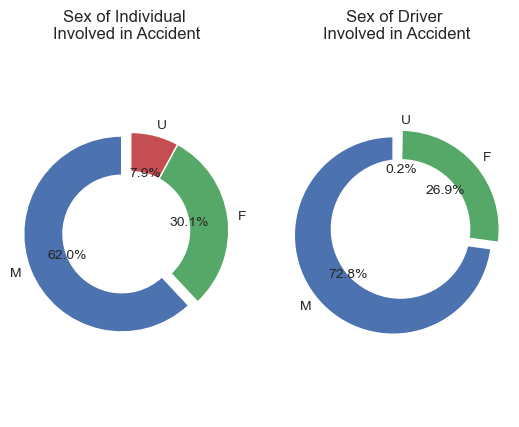

In [95]:
data2 = data.person_sex.value_counts()
labels = data2.index
counts = data2.values

fig, ax = plt.subplots(1, 2)
explode = (0.1, 0, 0)
ax[0].pie(
    counts, labels=labels, colors=deep_colors[:3], 
    autopct='%1.1f%%', startangle=90, 
    wedgeprops=dict(width=0.4), explode=explode
    )

centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax[0].axis('equal')
ax[0].set_title("Sex of Individual \nInvolved in Accident")

data2 = data.person_sex.value_counts()
labels = data2.index
counts = data2.values

# Second Plot
data2 = data.driver_sex.value_counts()
labels = data2.index
counts = data2.values
explode = (0.1, 0, 0)
ax[1].pie(
    counts, labels=labels, colors=deep_colors[:3], 
    autopct='%1.1f%%', startangle=90, 
    wedgeprops=dict(width=0.4), explode=explode
    )

centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax[1].axis('equal')
ax[1].set_title("Sex of Driver \nInvolved in Accident")
plt.show()


In [93]:
df.driver_sex.value_counts()

driver_sex
M    1659663
F     613643
U       5012
Name: count, dtype: int64

How distributed are accidents across Boroughs?

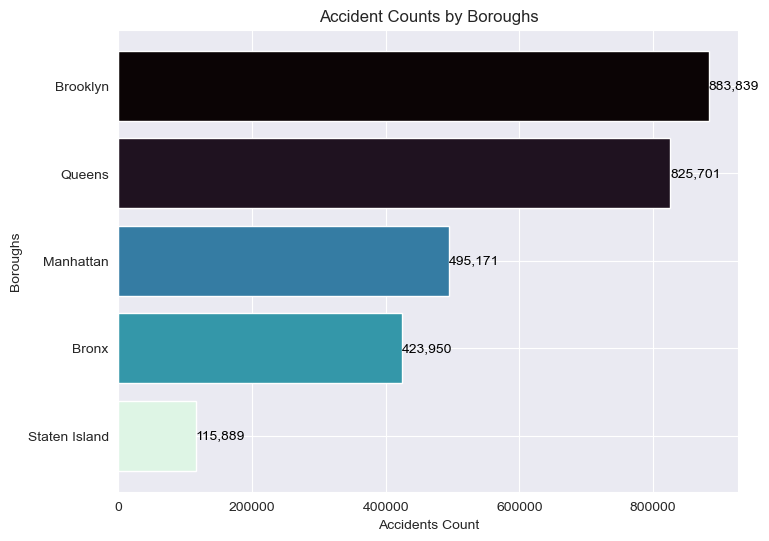

In [58]:
data2 = data.borough.value_counts()

cmap = plt.get_cmap('mako_r')
normalize = plt.Normalize(min(data2.values), max(data2.values))

plt.figure(figsize=(8, 6))
plt.barh(
    data2.index,
    data2.values,
    color=cmap(normalize(data2.values)), edgecolor='white'
)
for i, v in enumerate(data2.values.tolist()):
    plt.text(v + 0.5, i, str(f'{v:,.0f}'), color='black', va='center')


sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
sm.set_array([])

plt.ylabel('Boroughs')
plt.xlabel('Accidents Count')
plt.title('Accident Counts by Boroughs')
plt.gca().invert_yaxis()
plt.show()

Most recorded accidents affecct only the occupants of the accidented vehicle.

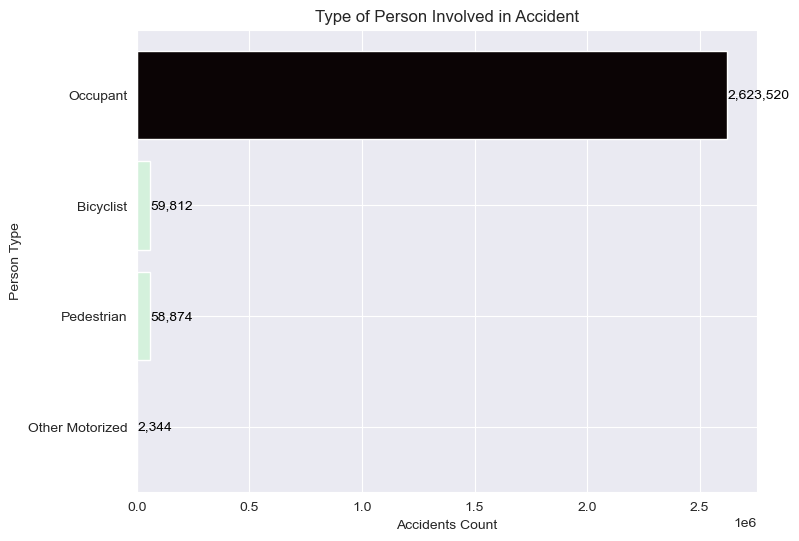

In [62]:
data2 = data.person_type.value_counts()

cmap = plt.get_cmap('mako_r')
normalize = plt.Normalize(min(data2.values), max(data2.values))

plt.figure(figsize=(8, 6))
plt.barh(
    data2.index,
    data2.values,
    color=cmap(normalize(data2.values)), edgecolor='white'
)
for i, v in enumerate(data2.values.tolist()):
    plt.text(v + 0.5, i, str(f'{v:,.0f}'), color='black', va='center')


sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
sm.set_array([])

plt.ylabel('Person Type')
plt.xlabel('Accidents Count')
plt.title('Type of Person Involved in Accident')
plt.gca().invert_yaxis()
plt.show()

Most victims have unspecified injuries and only 0.1% of accidents result in deaths. 

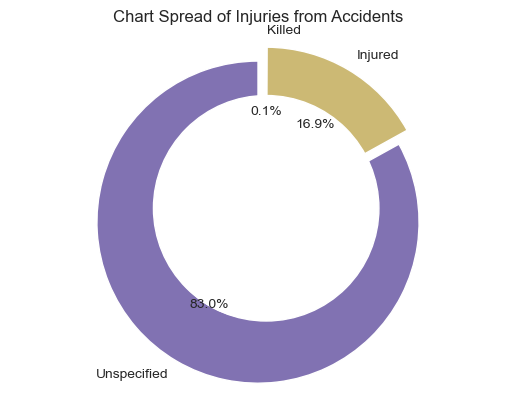

In [79]:
data2 = data.person_injury.value_counts()
labels = data2.index
counts = data2.values

fig, ax = plt.subplots()
explode = (0.1, 0, 0)
ax.pie(
    counts, labels=labels, colors=deep_colors[3:], 
    autopct='%1.1f%%', startangle=90, 
    wedgeprops=dict(width=0.4), explode=explode
    )


centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax.axis('equal')
ax.set_title("Chart Spread of Injuries from Accidents")
plt.show()

When we test for vehicles the registration of vehicles involved in accidents, mosst accidents invplve New York registered vehicles.

In [102]:
data2 = data.assign(
    state_registration=lambda x: x.state_registration.str.upper(),
    state_registration_bool=lambda x: x.state_registration.str.upper().apply(lambda i: 'In-State' if i=='NY' else 'Out-of-State'),
    driver_license_jurisdiction_bool=lambda x: x.driver_license_jurisdiction .str.upper().apply(lambda i: 'In-State' if i=='NY' else 'Unknown' if i is np.nan else 'Out-of-State')
)[['state_registration', 'state_registration_bool', 'driver_license_jurisdiction', 'driver_license_jurisdiction_bool']]

data2.head()

state_registration state_registration_bool  \
crash_datetime                                                   
2012-07-01 00:30:00                 NJ            Out-of-State   
2012-07-01 00:30:00                 NY                In-State   
2012-07-01 00:37:00                 NJ            Out-of-State   
2012-07-01 00:37:00                 NY                In-State   
2012-07-01 01:00:00                 NY                In-State   

                    driver_license_jurisdiction  \
crash_datetime                                    
2012-07-01 00:30:00                         NaN   
2012-07-01 00:30:00                         NaN   
2012-07-01 00:37:00                         NaN   
2012-07-01 00:37:00                         NaN   
2012-07-01 01:00:00                         NaN   

                    driver_license_jurisdiction_bool  
crash_datetime                                        
2012-07-01 00:30:00                          Unknown  
2012-07-01 00:30:00                          Unknown  
2012-07-01 00:37:00                          Unknown  
2012-07-01 00:37:00                          Unknown  
2012-07-01 01:00:00                          Unknown

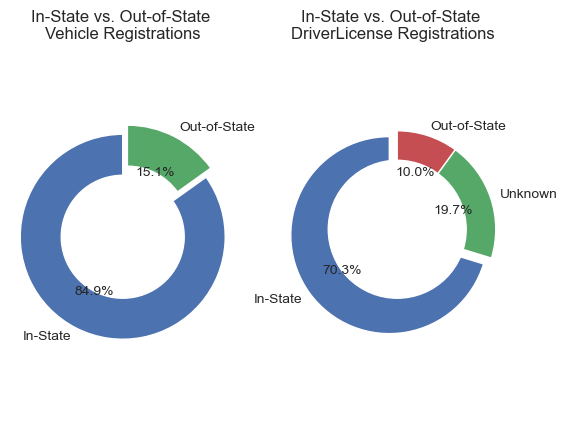

In [111]:
data3 = data2.state_registration_bool.value_counts()
labels = data3.index
counts = data3.values

fig, ax = plt.subplots(1, 2)
explode = (0.1, 0)
ax[0].pie(
    counts, labels=labels, colors=deep_colors[:2], 
    autopct='%1.1f%%', startangle=90, 
    wedgeprops=dict(width=0.4), explode=explode
    )

centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax[0].axis('equal')
ax[0].set_title("In-State vs. Out-of-State \nVehicle Registrations")

# 2nd Plot
data3 = data2.driver_license_jurisdiction_bool.value_counts()
labels = data3.index
counts = data3.values

explode = (0.1, 0, 0)
ax[1].pie(
    counts, labels=labels, colors=deep_colors[:3], 
    autopct='%1.1f%%', startangle=90, 
    wedgeprops=dict(width=0.4), explode=explode
    )

centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax[1].axis('equal')
ax[1].set_title("In-State vs. Out-of-State \nDriverLicense Registrations")

plt.show()

For vehicle types, the Sedan and the SUV are the cars most involved in accidents.

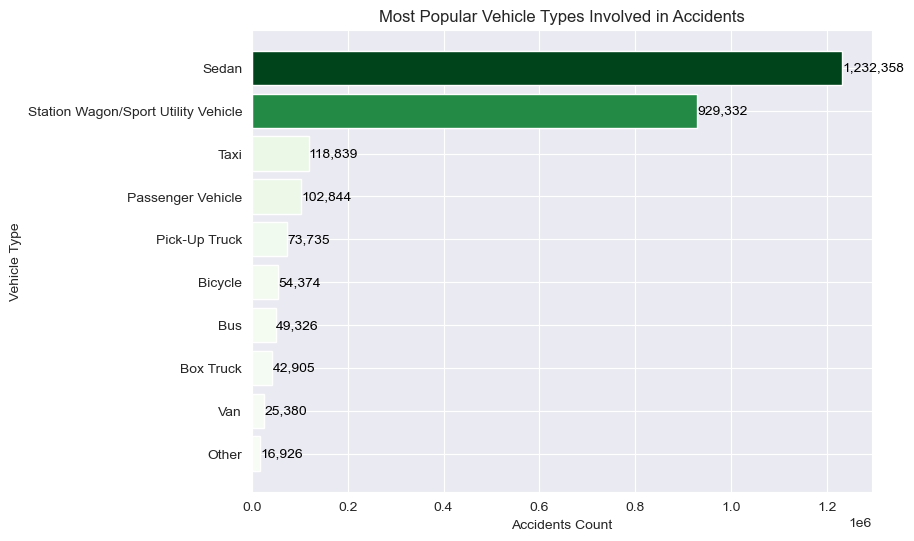

In [90]:
data2 = data.vehicle_type.value_counts(dropna=False).head(10)

cmap = plt.get_cmap('Greens')
normalize = plt.Normalize(min(data2.values), max(data2.values))

plt.figure(figsize=(8, 6))
plt.barh(
    data2.index,
    data2.values,
    color=cmap(normalize(data2.values)), edgecolor='white'
)
for i, v in enumerate(data2.values.tolist()):
    plt.text(v + 0.5, i, str(f'{v:,.0f}'), color='black', va='center')


sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
sm.set_array([])

plt.ylabel('Vehicle Type')
plt.xlabel('Accidents Count')
plt.title('Most Popular Vehicle Types Involved in Accidents')
plt.gca().invert_yaxis()
plt.show()

Most accidents occur with Northbound drivers. However, the spread difference across travel directions is not very large.

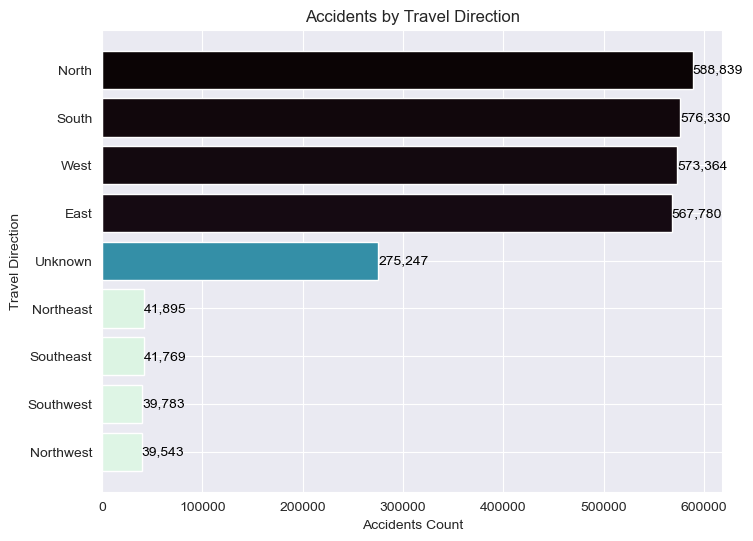

In [92]:
data2 = data.travel_direction.value_counts(dropna=False)

cmap = plt.get_cmap('mako_r')
normalize = plt.Normalize(min(data2.values), max(data2.values))

plt.figure(figsize=(8, 6))
plt.barh(
    data2.index,
    data2.values,
    color=cmap(normalize(data2.values)), edgecolor='white'
)
for i, v in enumerate(data2.values.tolist()):
    plt.text(v + 0.5, i, str(f'{v:,.0f}'), color='black', va='center')


sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
sm.set_array([])

plt.ylabel('Travel Direction')
plt.xlabel('Accidents Count')
plt.title('Accidents by Travel Direction')
plt.gca().invert_yaxis()
plt.show()

In [63]:
data.columns

Index(['borough', 'person_type', 'person_sex', 'person_injury',
       'state_registration', 'vehicle_type', 'travel_direction', 'driver_sex',
       'driver_license_status', 'driver_license_jurisdiction', 'pre_crash',
       'point_of_impact', 'vehicle_damage', 'vehicle_damage_1',
       'vehicle_damage_2', 'vehicle_damage_3', 'public_property_damage',
       'contributing_factor_1', 'contributing_factor_2', 'on_street_name',
       'cross_street_name', 'ejection', 'emotional_status', 'bodily_injury',
       'position_in_vehicle'],
      dtype='object')

**Variable Relationships**

13. Injured vs Killed stats
14. Relationship between Complainant and person injured
15. Vehicle Damage vs Vehicle Make, Vehicle Type, Registration Year, Driver Sex, Point of Impact and Travel Direction


**Supplemental Analysis**

16. Understanding these features - Ejection, Emotional status, Bodily injury, Position in vehicle, Safety equipment, Ped role

**Conclusion & Recommendations**

17. Provide recommendations to reduce the occurrence of accidents